# <center> Обучение с учителем. Классификация
## <center> Предсказываем категорию дохода человека
<img src=https://blondeblog.ru/wp-content/uploads/2018/09/2.jpg.jpg>

In [1]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

In [2]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

### Описание задачи

Данные, с которыми мы будем работать были извлечены из базы данных **Бюро переписи населения 1994 года** Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной - предсказание дохода.

Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50K $.


**Знакомство с данными**

Набор данных вы можете скачать по [ссылке](https://lms.skillfactory.ru/assets/courseware/v1/f0202a25c7f53289bcaed630d2813271/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/adult.zip).

In [3]:
data = pd.read_csv('data/adult.zip')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

Проверяем наличие пропусков

In [4]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [5]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [6]:
data.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Смотрим на сбалансированность классов:

income
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64

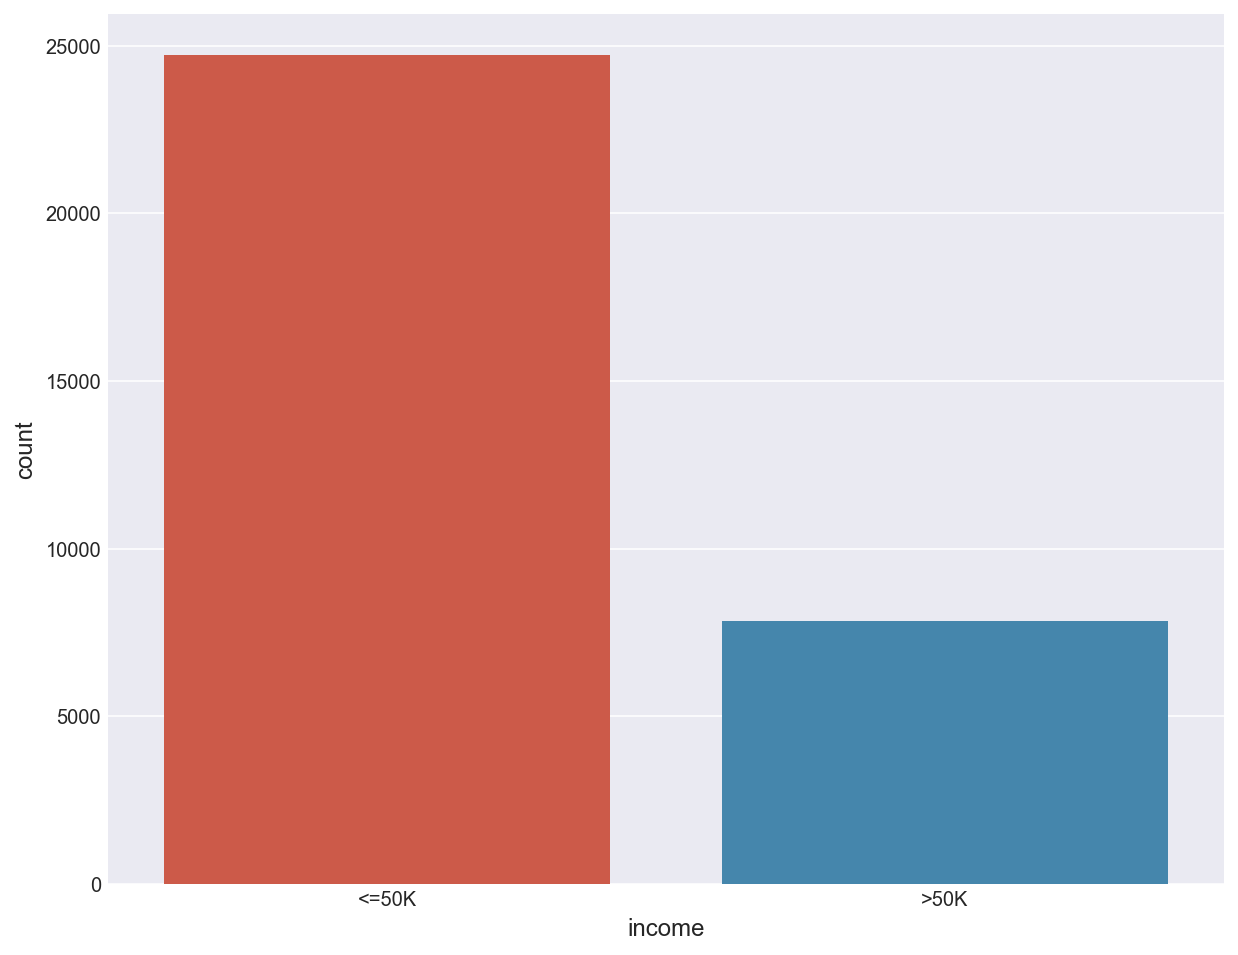

In [7]:
sns.countplot(data=data, x='income');
data['income'].value_counts(True) * 100

Для удобства переобозначим целевой признак (не обязательный шаг)

In [8]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [9]:
cat_features = data.select_dtypes(include=['object']).columns.to_list()
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

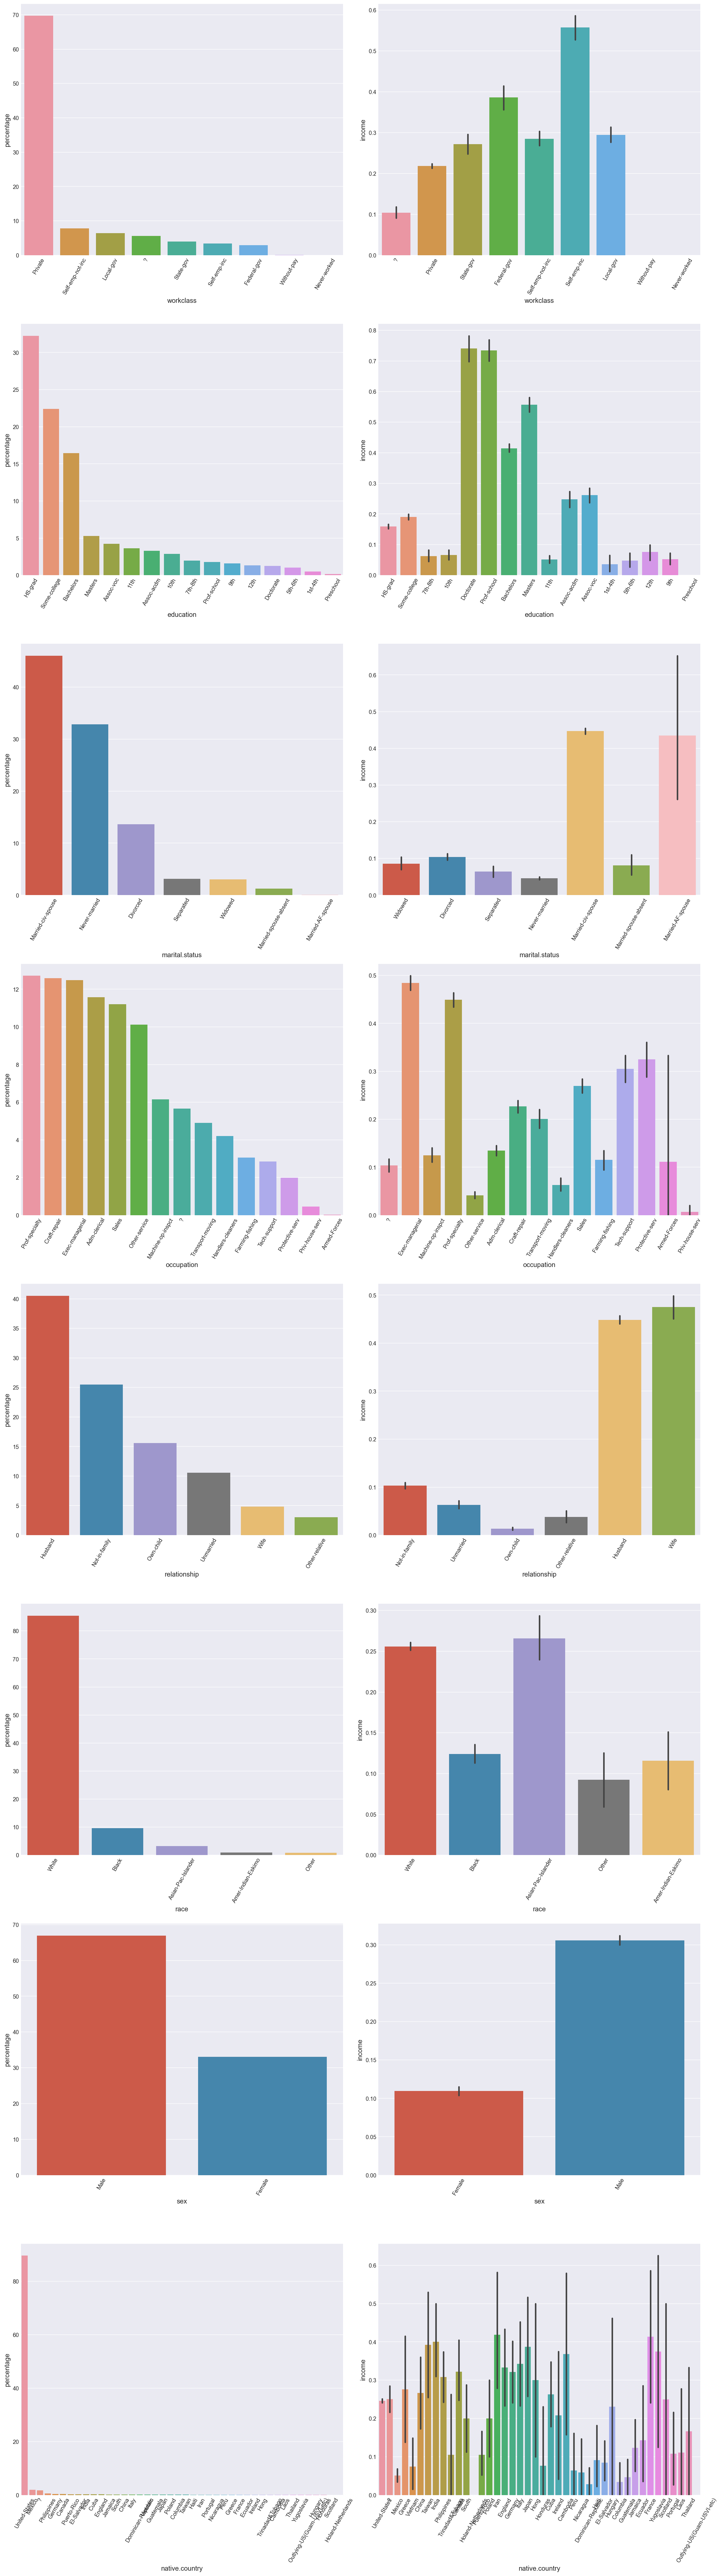

In [10]:
n = len(cat_features) # число категориальных признаков

fig, axes = plt.subplots(n, 2, figsize=(18, 8 * n)) # фигура+n*2 координатных плоскостей

# Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    # Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = ((data[feature].value_counts(normalize=True) * 100)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    
    count_barplot = sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    
    # Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
    
plt.tight_layout() # выравнивание графиков

В чем суть графиков выше. Втизуализировав доли классов отдельных признаков, какие они занимают в целевом признаке можно классы отдельные обобщить и объеденить, если их доли схожи.

Пример это классы обучениея, где вся средняя школа фактически один класс, школьники, разделение тут глубокое бесмысленно.

### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [11]:
adult_data = data.copy()

# Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)

adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'Self and gov' if x == 'Self-emp-not-inc' or x == 'Local-gov' or x == 'State-gov' else x
)
# Self-emp-not-inc + Local-gov в одну категорию. Может быть сюда добавить еще State-gov


# Определяем школьников в отдельную категорию
# Preschool попробовать объеденить с School совсем низкая доля у этой категории
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' or x == 'Preschool' else x
)

# Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)

# Два типа колледжей соссем рядом по размеру столбцы которые эти категории занимают в income
# Попробовать объеденить в одну категорию HS-grad и Some-college
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'College' if x == 'HS-grad' or x == 'Some-college' else x
)

# Объеденить Doctorate и Prof-school
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Prof' if x == 'Doctorate' or x == 'Prof-school' else x
)

# Объединяем вдовцов, разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated' or x == 'Married-spouse-absent') else x
)
# Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-AF-spouse') else x
)


# Married-spouse-absent вытащить из этой категории и попробовать впихнуть в предыдущую, это ведь практически развод, просто не оформленный

# occupation
# Farming-fishing и ? в одну группу
# Machine-op-inspct и Adm-clerical
# Craft-repair и Transport-moving
# Tech-support и Protective-serv
adult_data['occupation'] = adult_data['occupation'].apply(
    lambda x: 'gr1' if (x == 'Farming-fishing' or x == '?') else x
)

adult_data['occupation'] = adult_data['occupation'].apply(
    lambda x: 'gr2' if (x == 'Machine-op-inspct' or x == 'Adm-clerical') else x
)

adult_data['occupation'] = adult_data['occupation'].apply(
    lambda x: 'gr3' if (x == 'Craft-repair' or x == 'Transport-moving') else x
)

adult_data['occupation'] = adult_data['occupation'].apply(
    lambda x: 'gr4' if (x == 'Tech-support' or x == 'Protective-serv') else x
)

# Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'Family' if (x == 'Husband' or x == 'Wife') else x
)

adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'Not family' if (x == 'Not-in-family' or x == 'Unmarried' or x == 'Other-relative') else x
)

# Тут бы я попробовал own-child оставить в отдельной категории и доля высока и по логике выделяется и по значению дохода
# Husband, Wife в одну группу
# Not-in-family, Unmarried, Other-relative в одну категорию
# В отдельную категорию Own-child

# race
# В одну группу White, Asian-Pac-Islander в одругую группу все остальное Black, Other, Amer-Indian-Eskimo
adult_data['race'] = adult_data['race'].apply(
    lambda x: 'race1' if (x == 'White' or x == 'Asian-Pac-Islander' or x == 'Other-relative') else 'race2'
)

# Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

In [12]:
adult_data['relationship'].value_counts()

relationship
Family        14761
Not family    12732
Own-child      5068
Name: count, dtype: int64

Предобрабатываем числовые признаки

In [13]:
num_features = adult_data.select_dtypes(exclude=['object']).columns.to_list()
num_features

['age',
 'fnlwgt',
 'education.num',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'income']

Визуализирую распределения числовых признаков, логарифмирую их и добавляю границы по методу 3х сигм

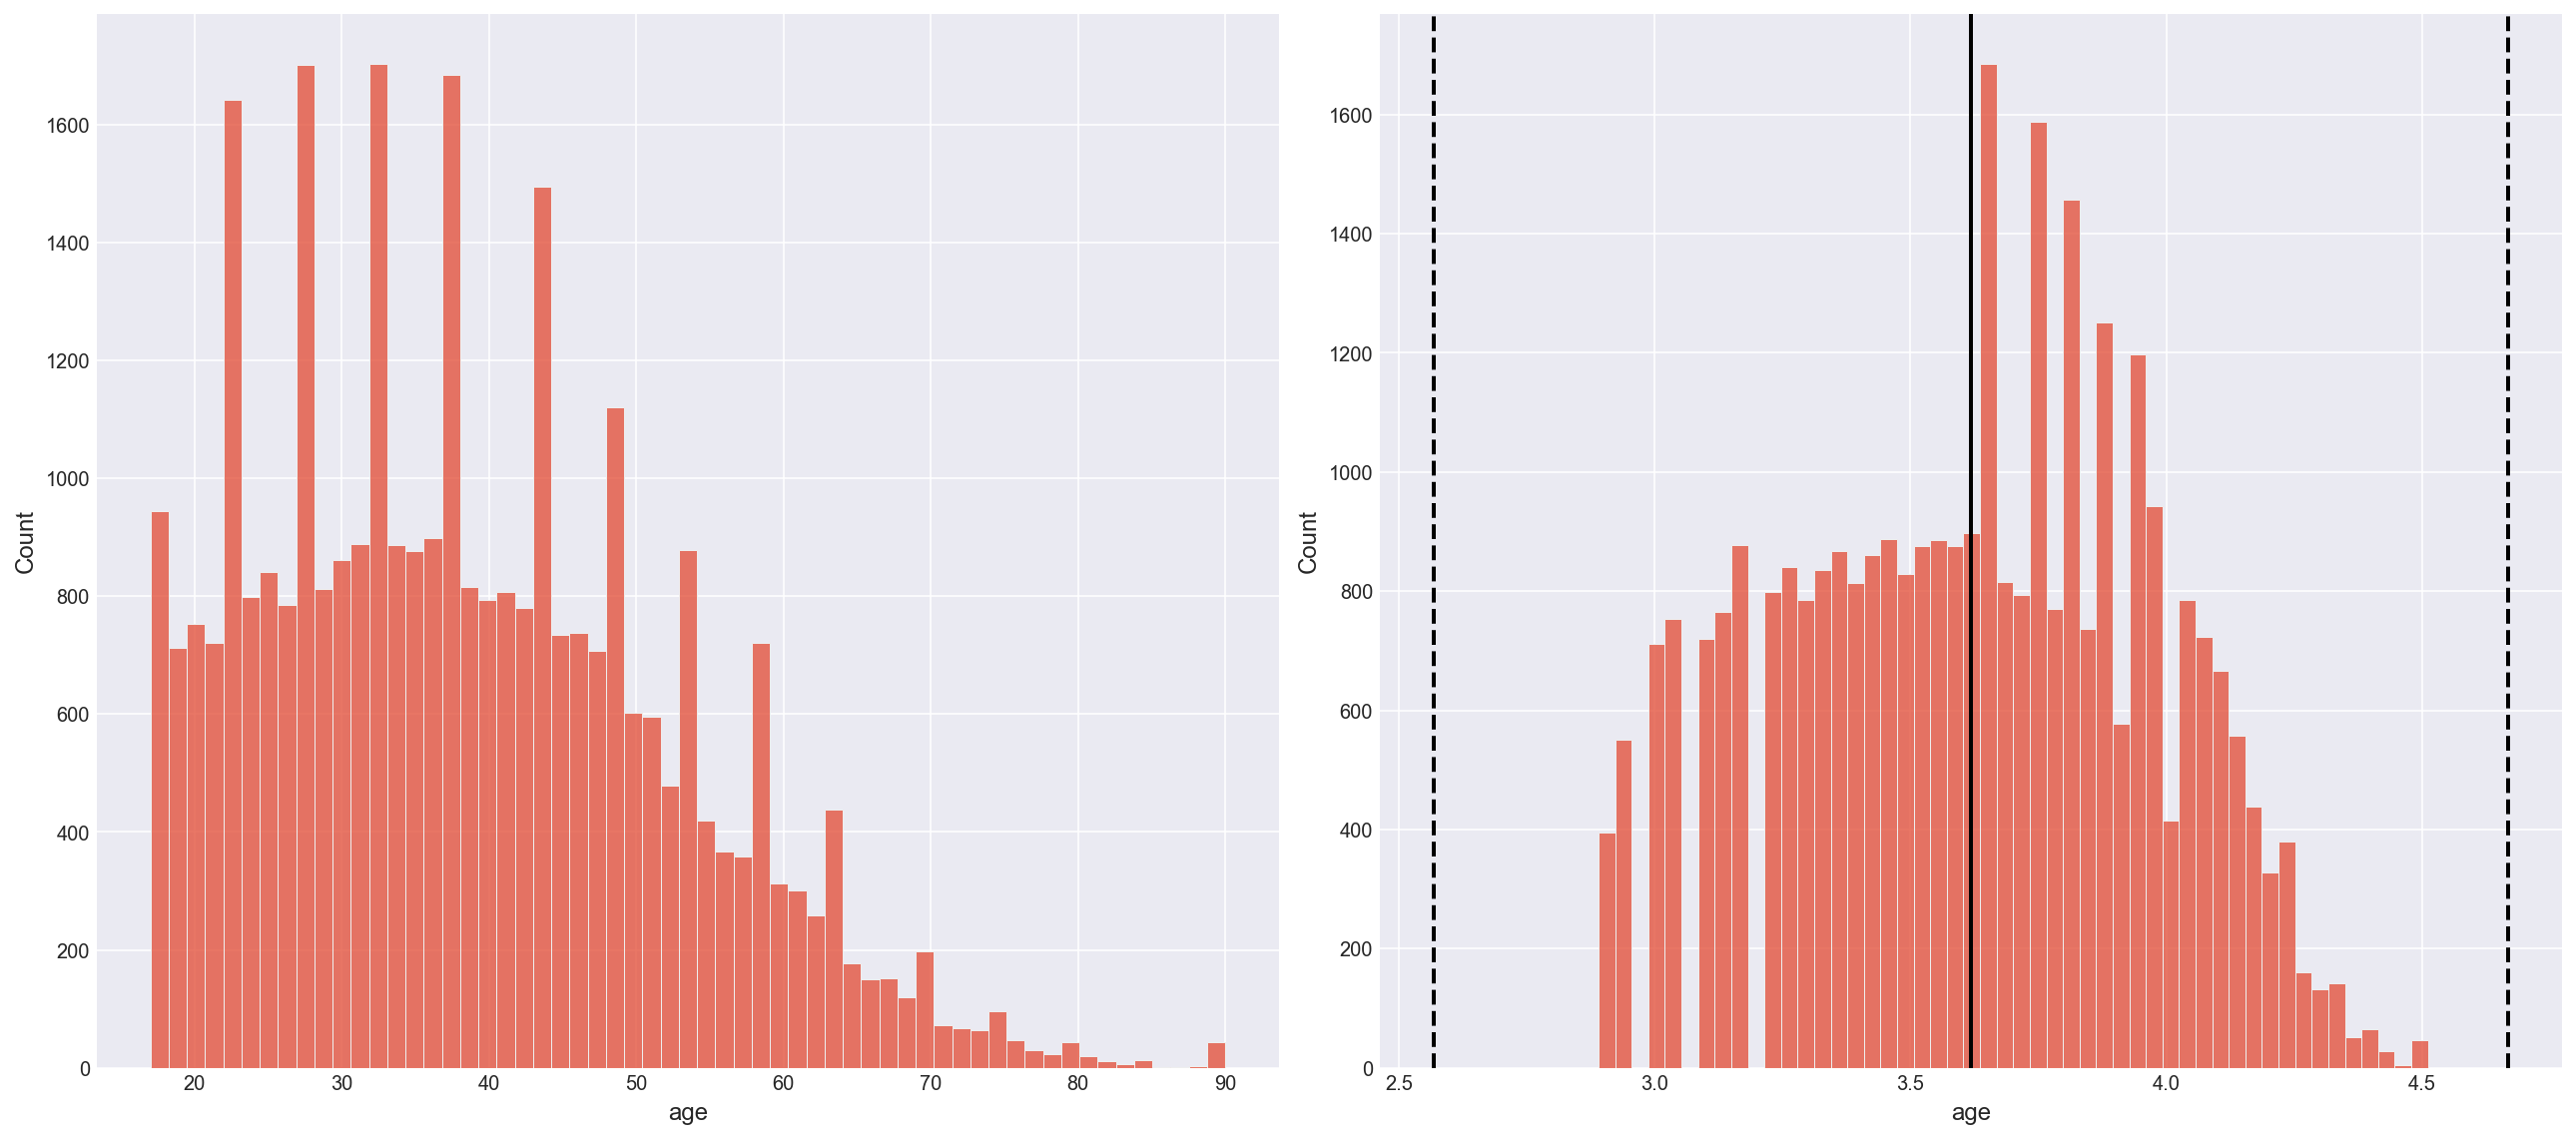

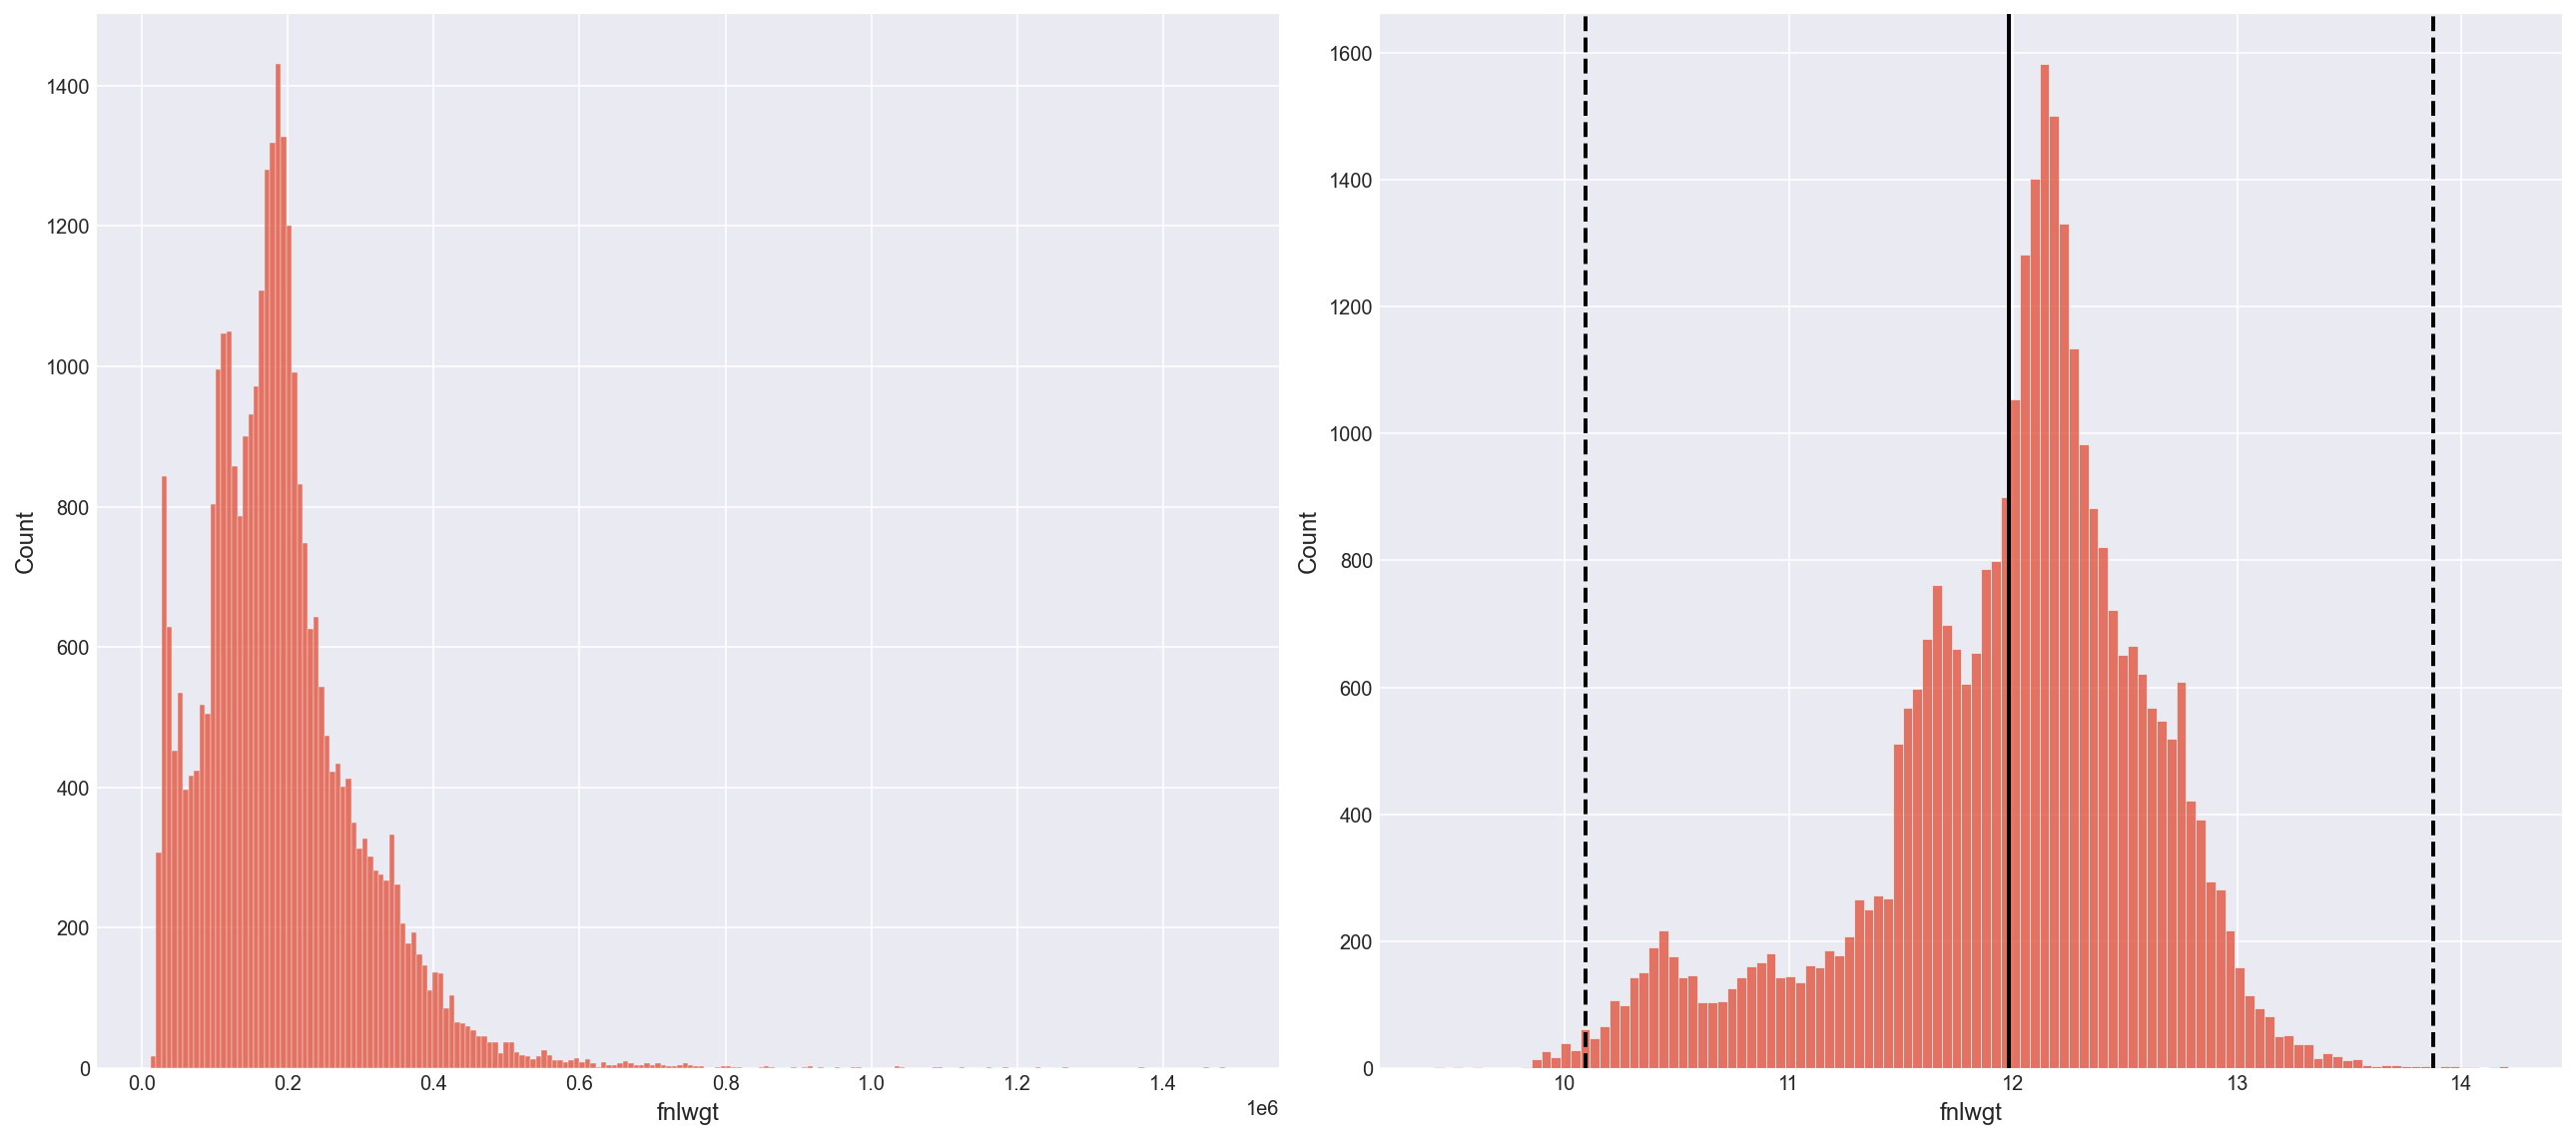

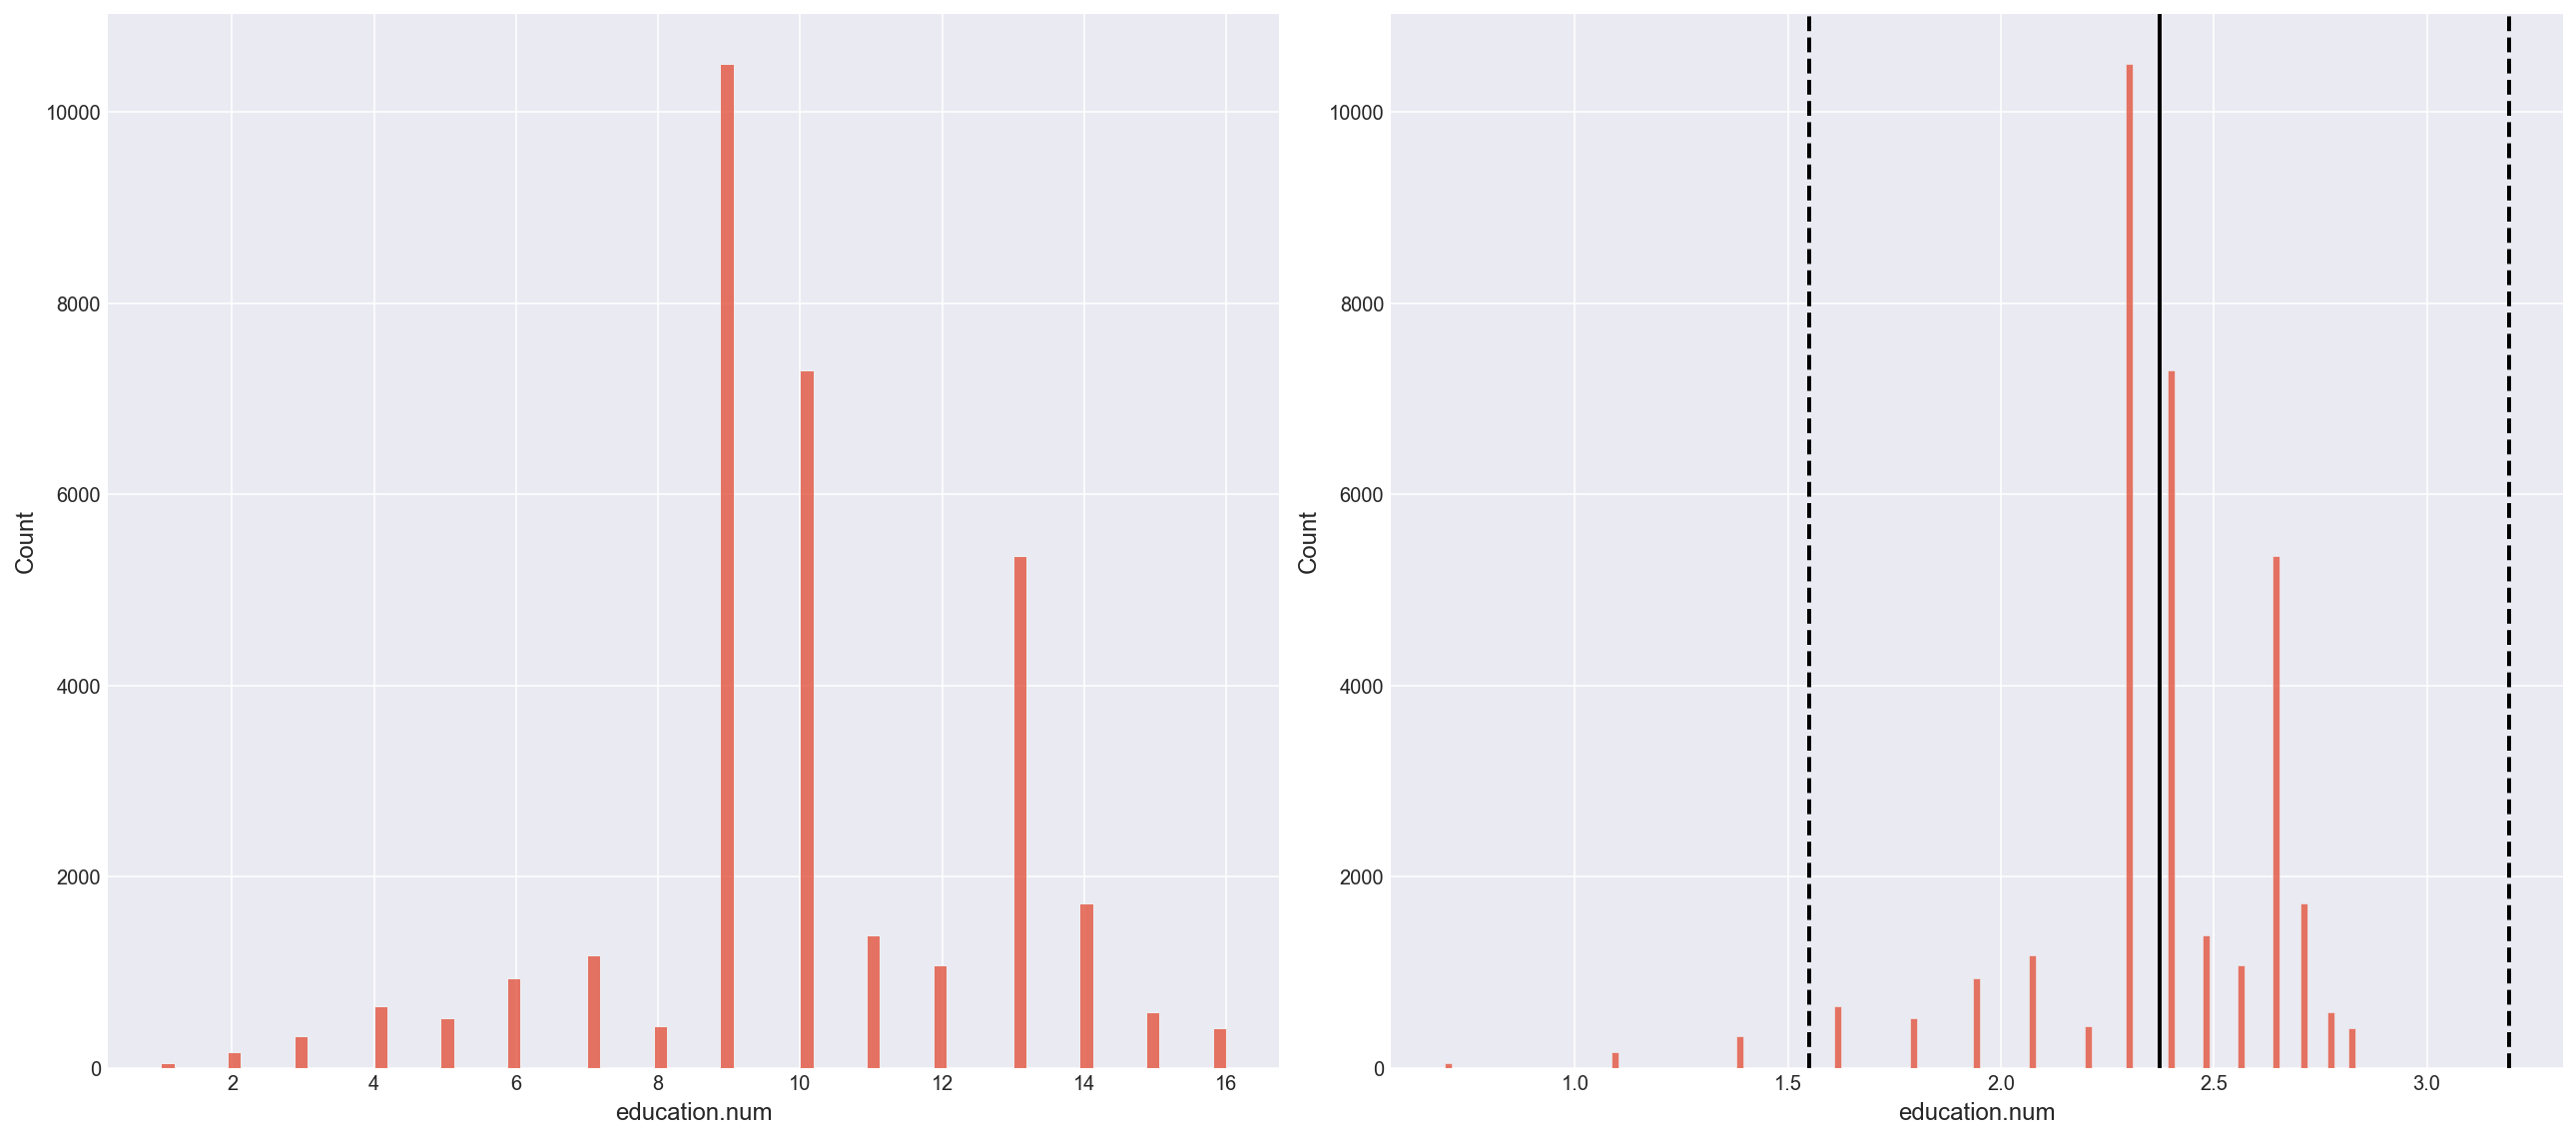

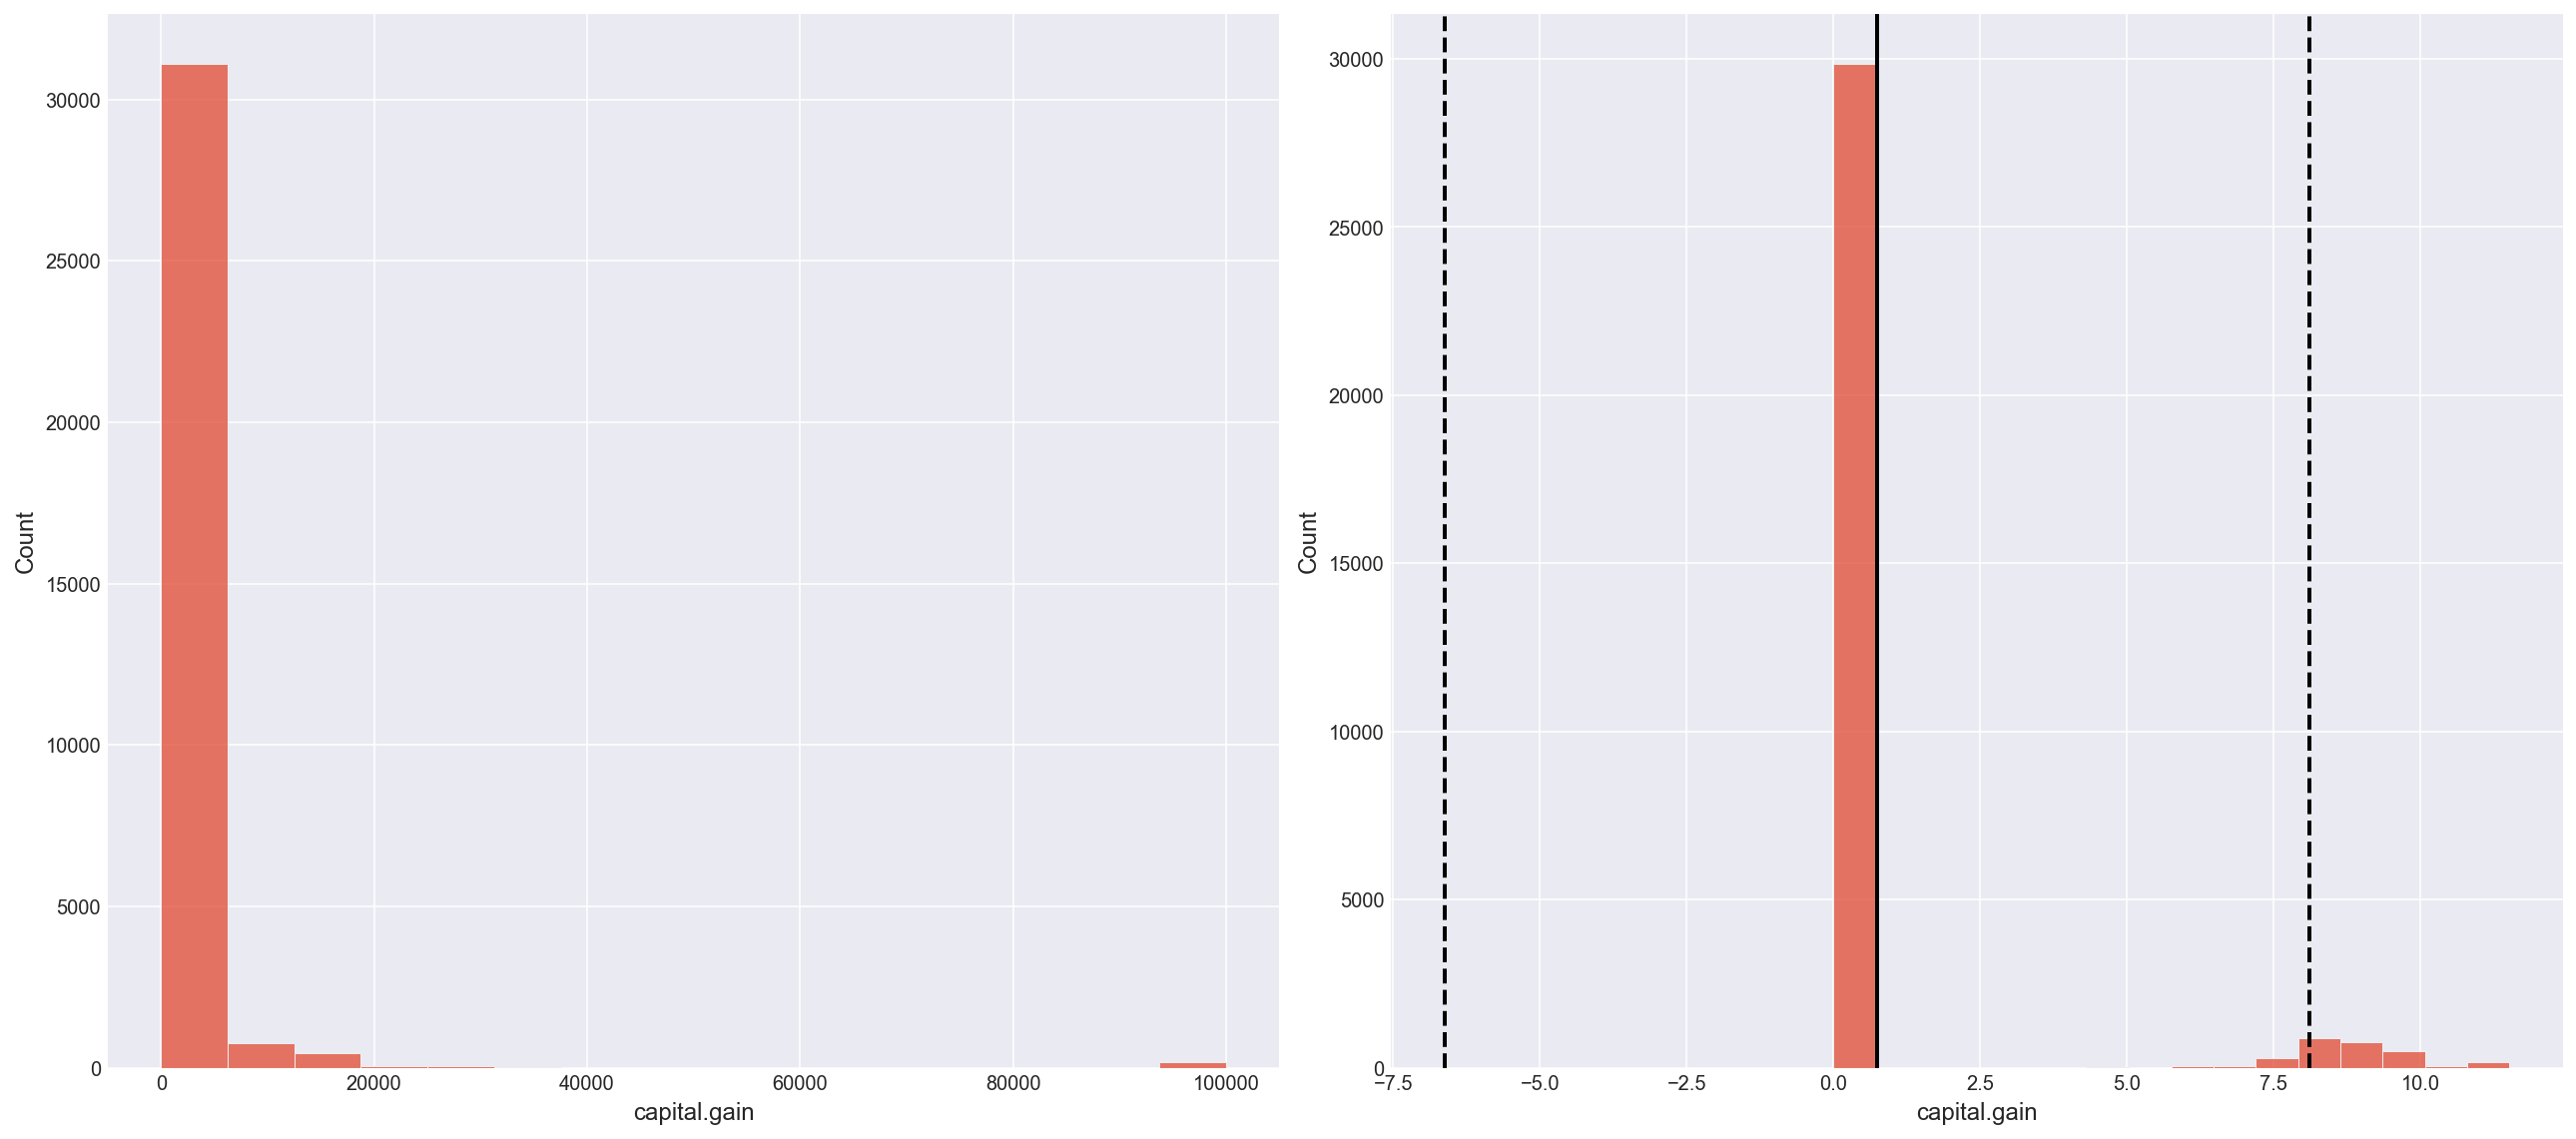

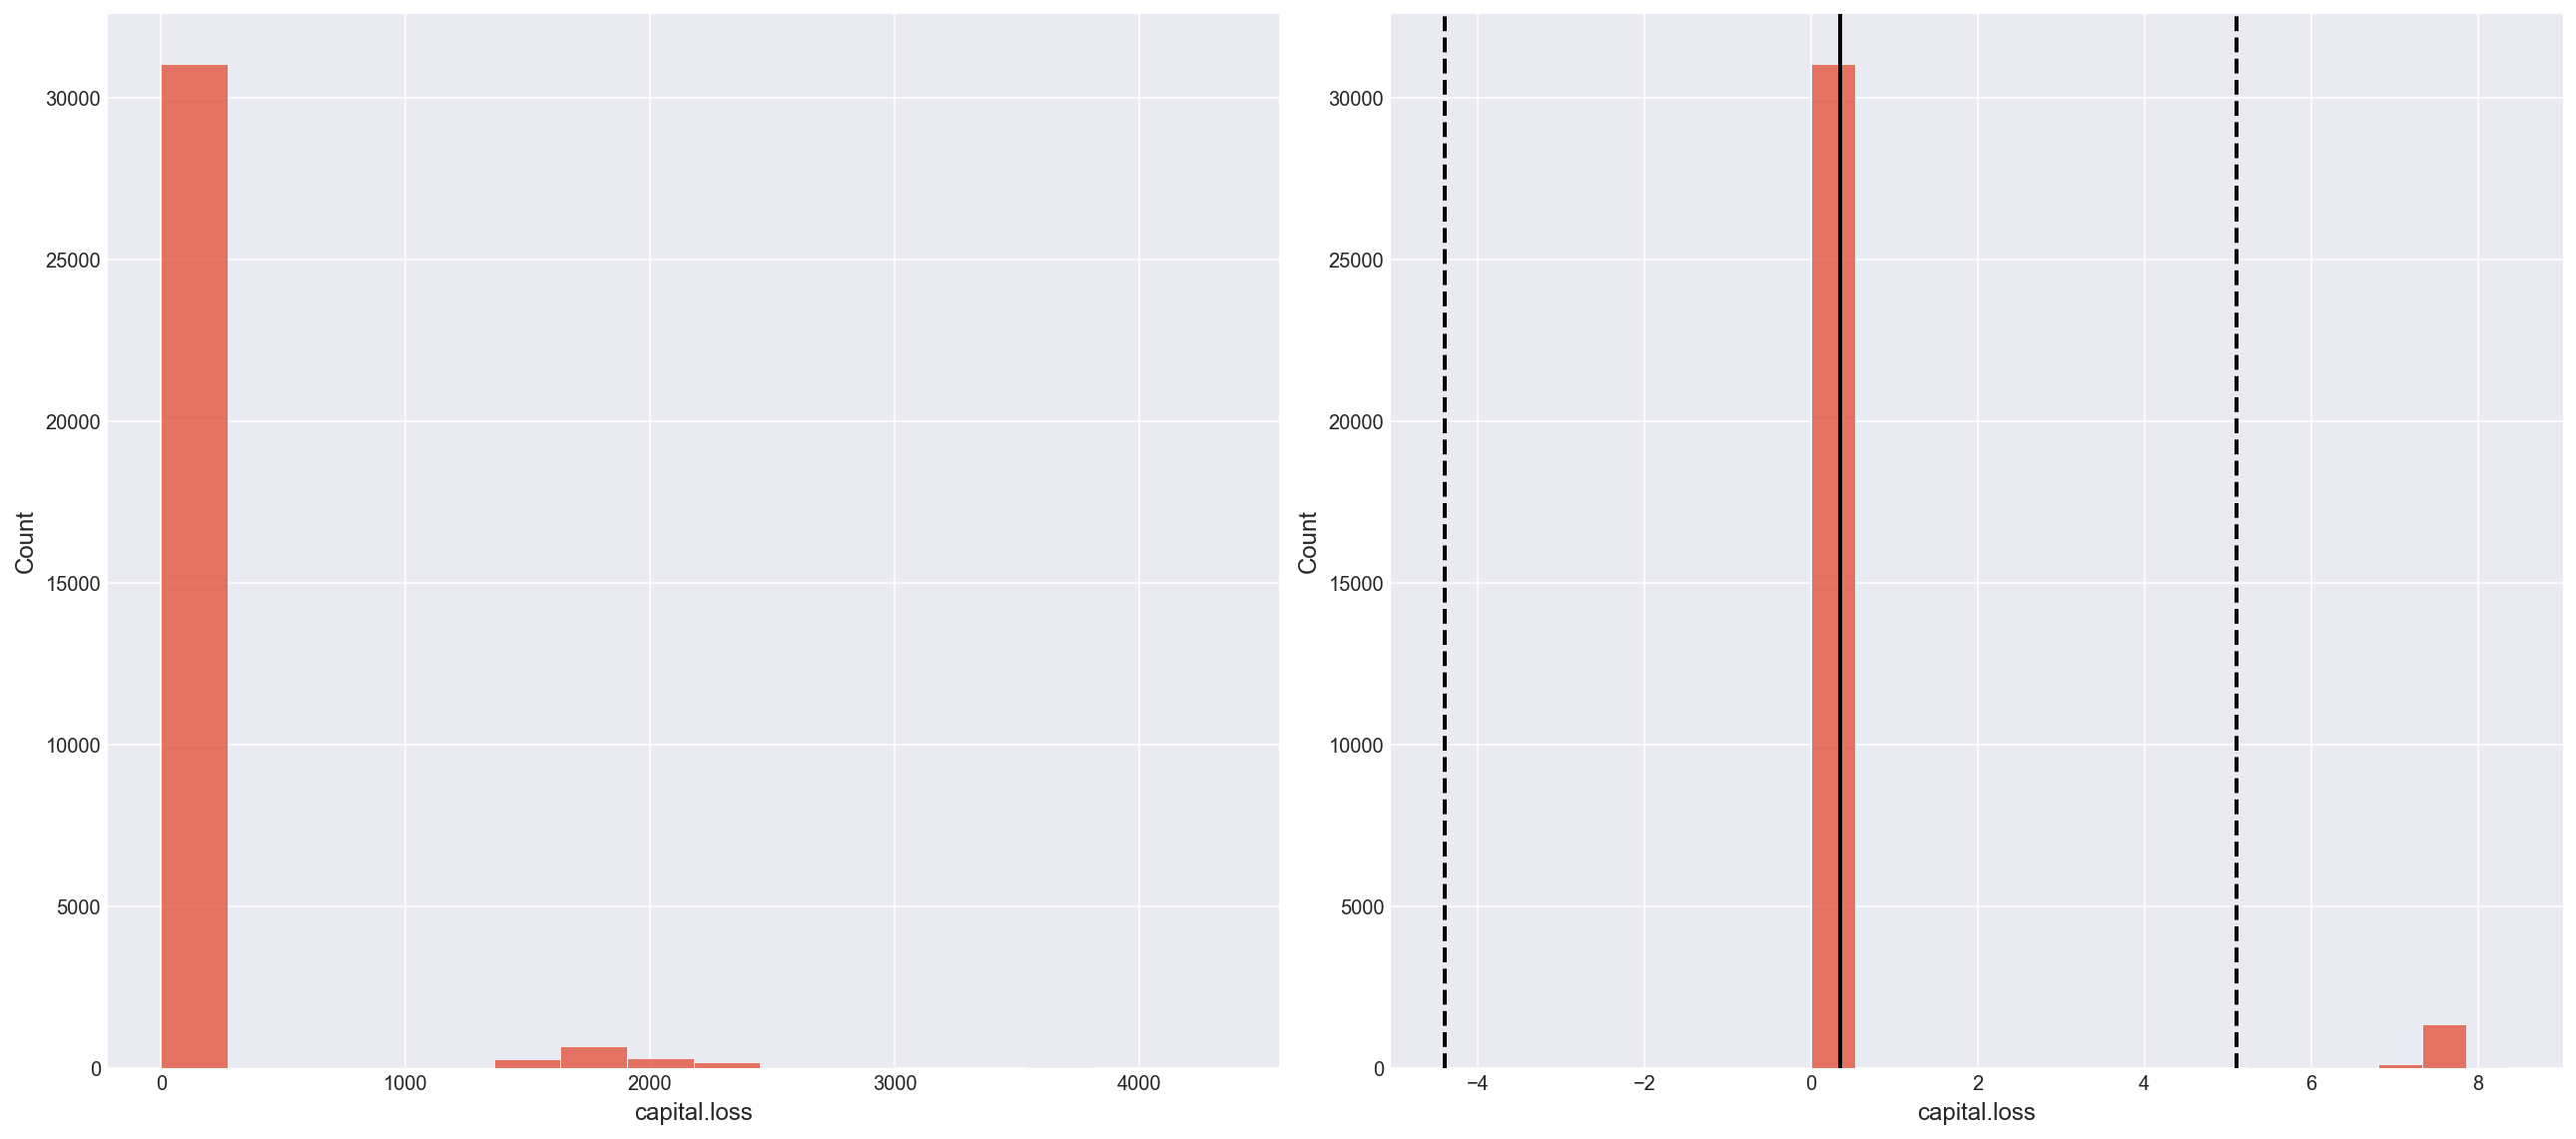

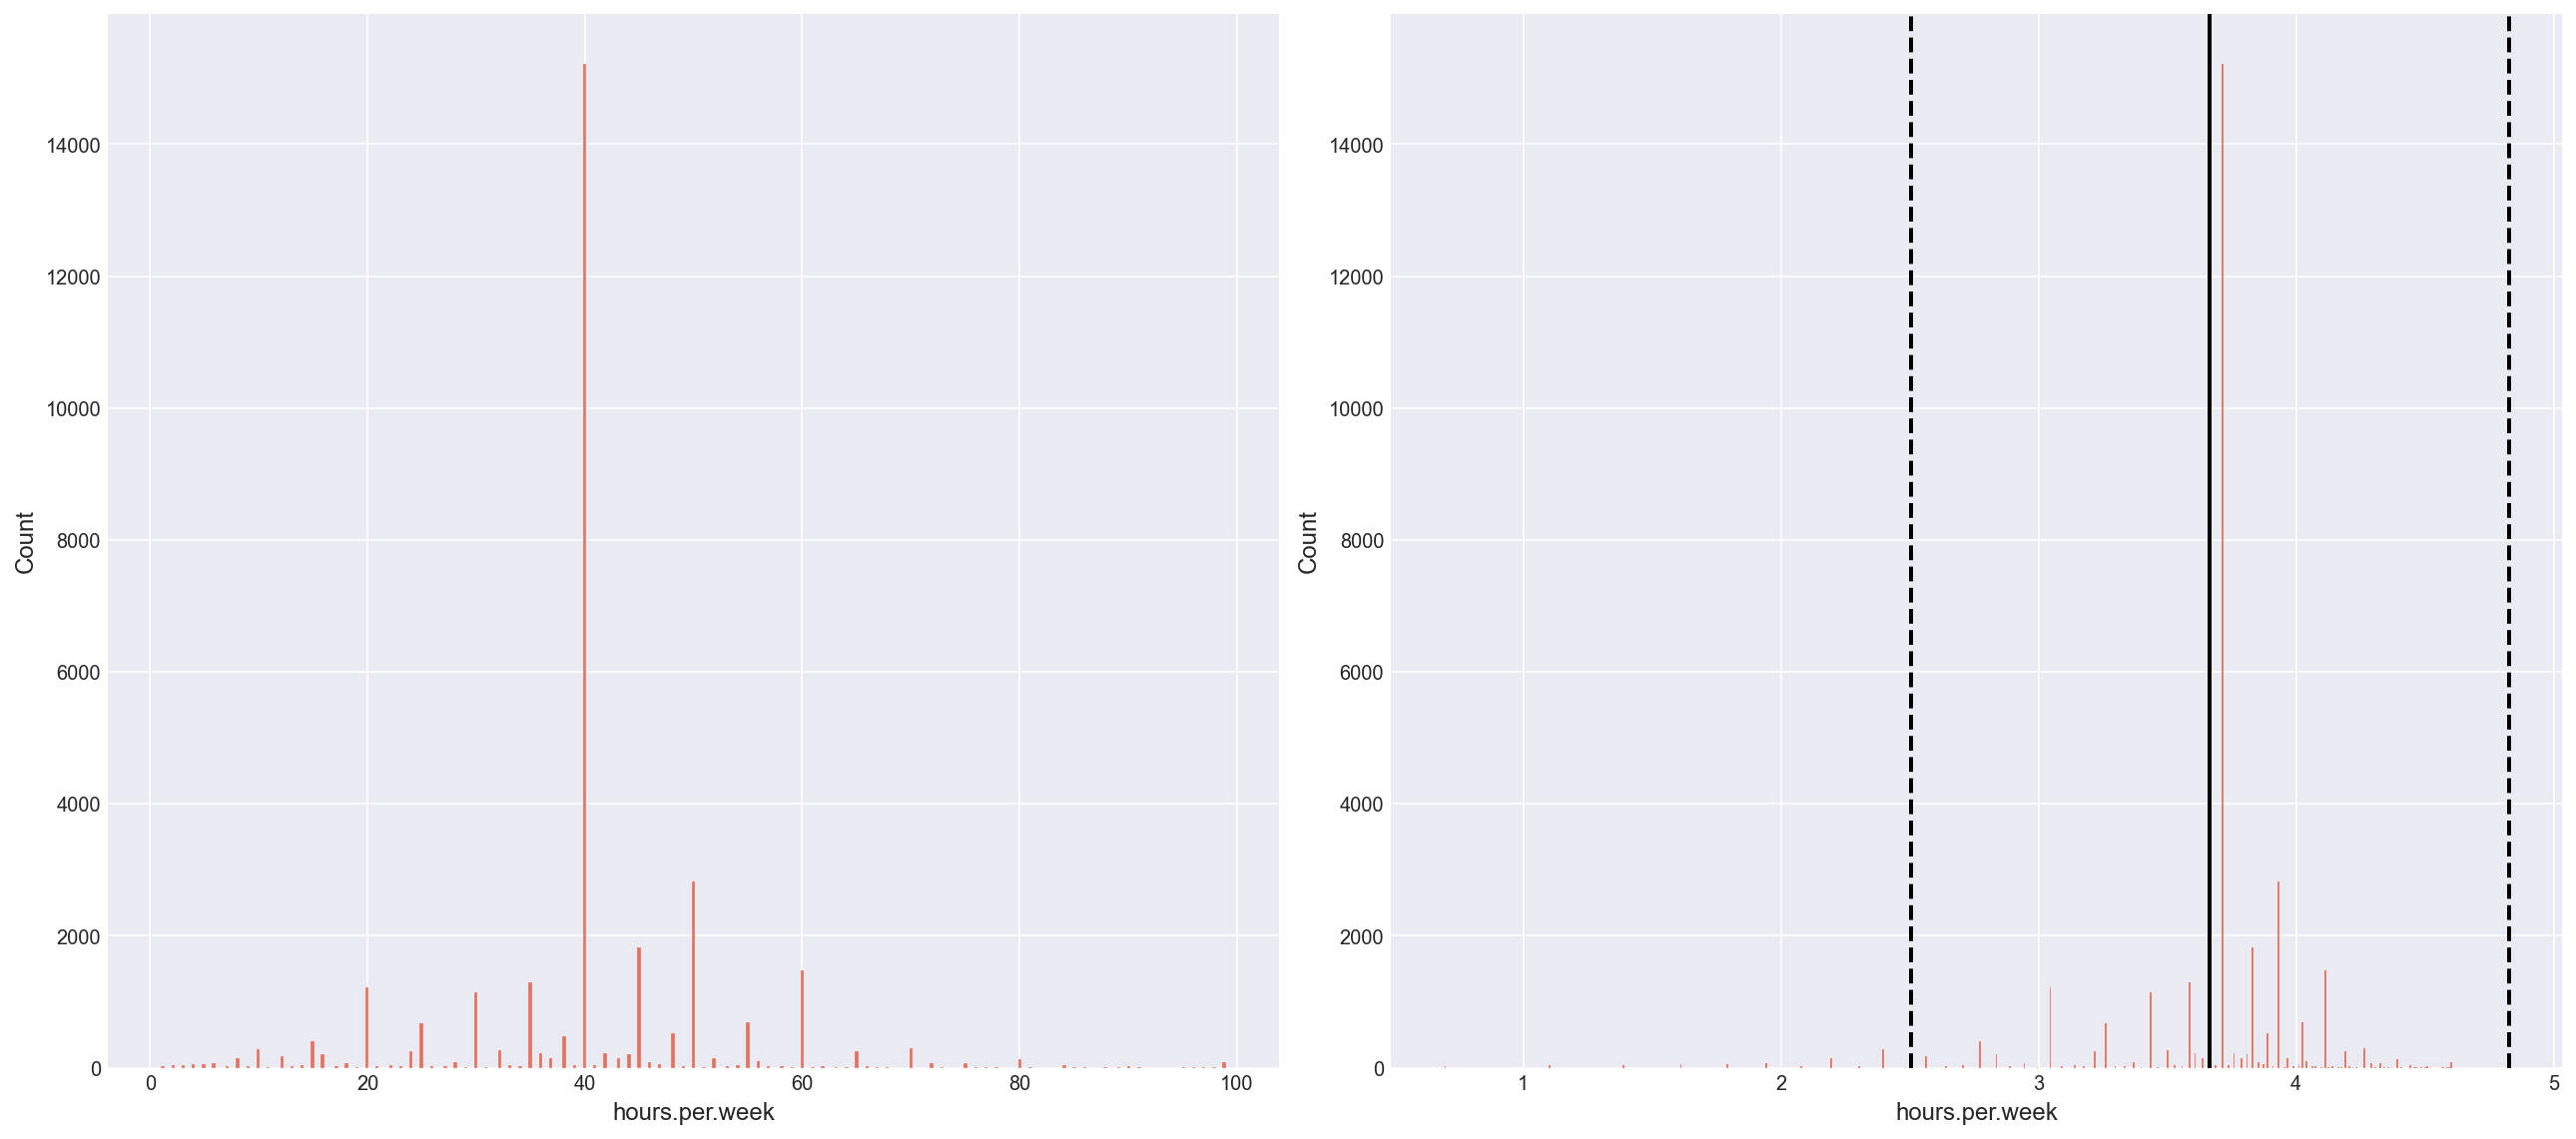

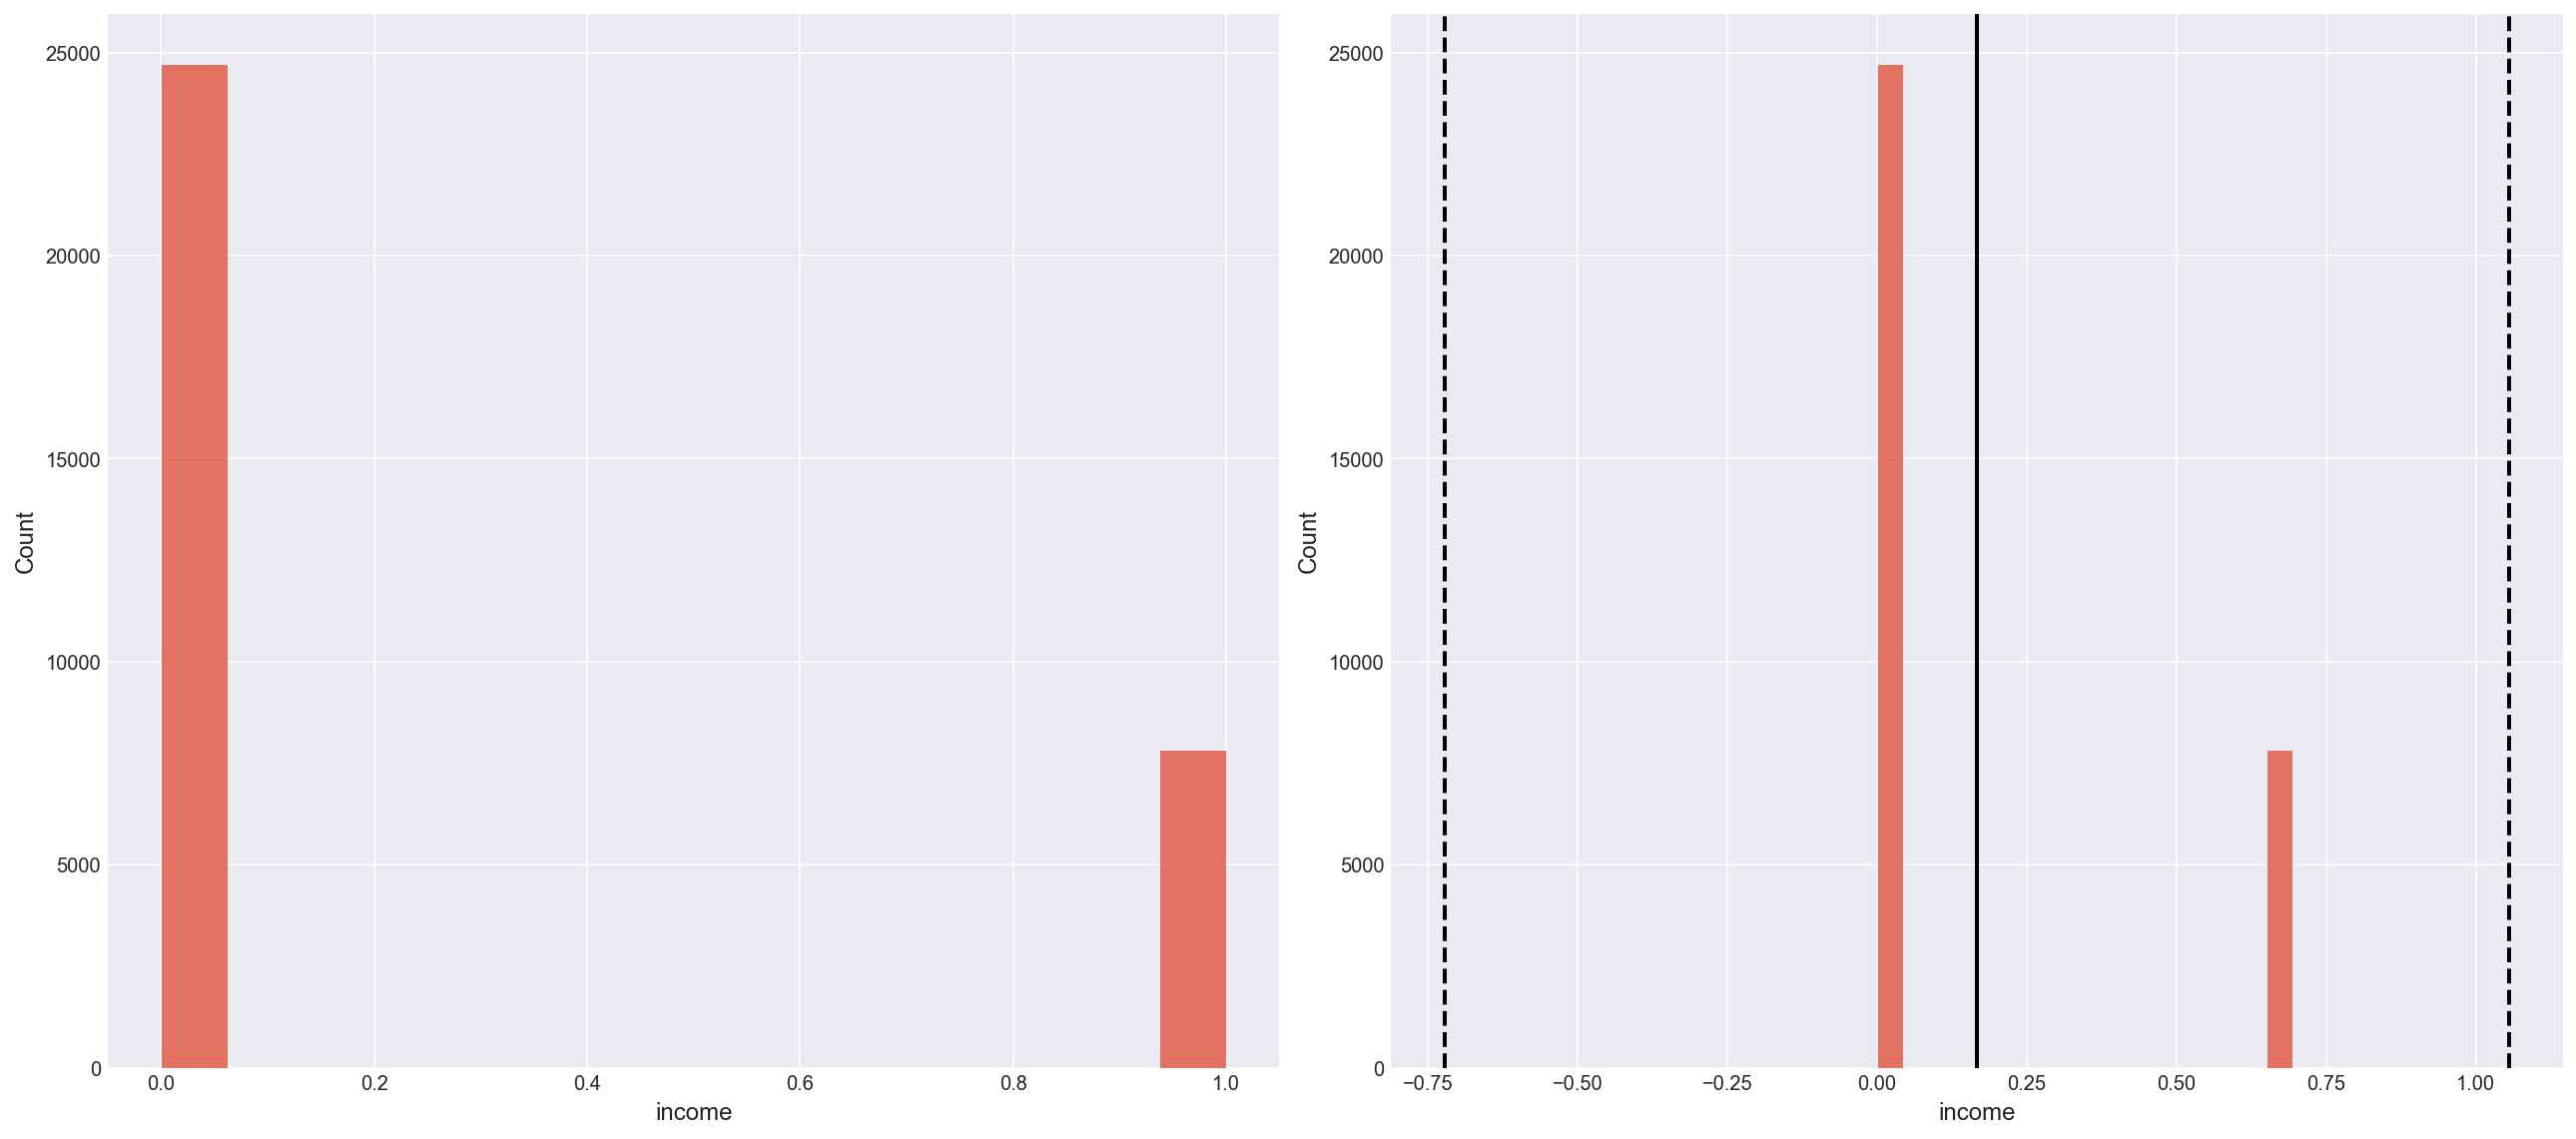

In [14]:
for col in num_features:
    hd.plot_outliers_z_score(adult_data, col, log_scale=True)

In [15]:
# Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

# Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [16]:
# Удаляем лишние признаки
adult_data.drop(columns=['education.num', 'capital.gain', 'capital.loss'], inplace=True)

Проверяем результаты предобработки

In [17]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,6,6,3,11,3,2,2,2
top,Private,College,Married,gr2,Family,race1,Male,United-States
freq,22696,17792,14999,5772,14761,28855,21790,29170


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

In [18]:
adult_data

,age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income,capital_diff
0,90,?,11.252262,College,Prev-Married,gr1,Not family,race1,Female,40,United-States,0,8.379539
1,82,Private,11.797134,College,Prev-Married,Exec-managerial,Not family,race1,Female,18,United-States,0,8.379539
2,66,?,12.133835,College,Prev-Married,gr1,Not family,race2,Female,40,United-States,0,8.379539
3,54,Private,11.851966,School,Prev-Married,gr2,Not family,race1,Female,40,United-States,0,8.268988
4,41,Private,12.486216,College,Prev-Married,Prof-specialty,Own-child,race1,Female,40,United-States,0,8.268988
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,12.644821,College,Never-married,gr4,Not family,race1,Male,40,United-States,0,0.000000
32557,27,Private,12.458010,Associate,Married,gr4,Family,race1,Female,38,United-States,0,0.000000
32558,40,Private,11.947140,College,Married,gr2,Family,race1,Male,40,United-States,1,0.000000
32559,58,Private,11.931050,College,Prev-Married,gr2,Not family,race1,Female,40,United-States,0,0.000000


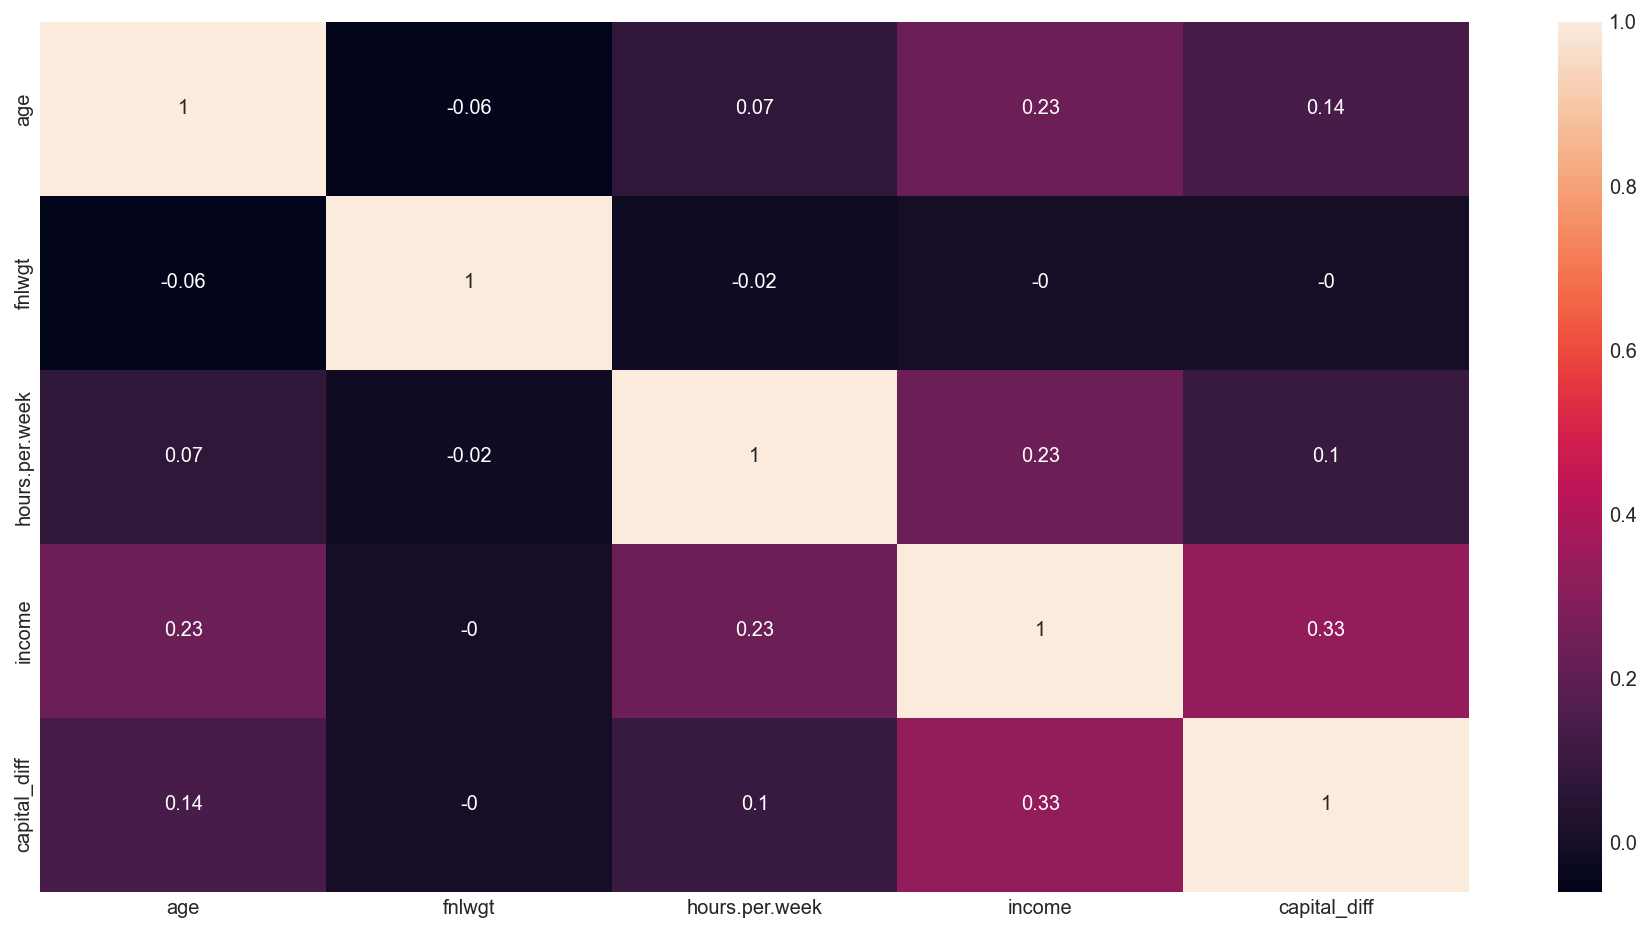

In [19]:
plt.figure(figsize=(16, 8))
sns.heatmap(adult_data.select_dtypes(include='number').corr().round(2), annot=True);

Кодируем текстовые категориальные признаки

In [20]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_No income,workclass_Private,workclass_Self and gov,workclass_Self-emp-inc,...,occupation_Sales,occupation_gr1,occupation_gr2,occupation_gr3,occupation_gr4,relationship_Not family,relationship_Own-child,race_race2,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,True
1,82,11.797134,18,0,8.379539,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
2,66,12.133835,40,0,8.379539,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,True
3,54,11.851966,40,0,8.268988,False,False,True,False,False,...,False,False,True,False,False,True,False,False,False,True
4,41,12.486216,40,0,8.268988,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True


После перекодировки можно построить корреляционную матрицу по всем признакам.
Но это так, чисто для понимания. В этом проекте не использую.

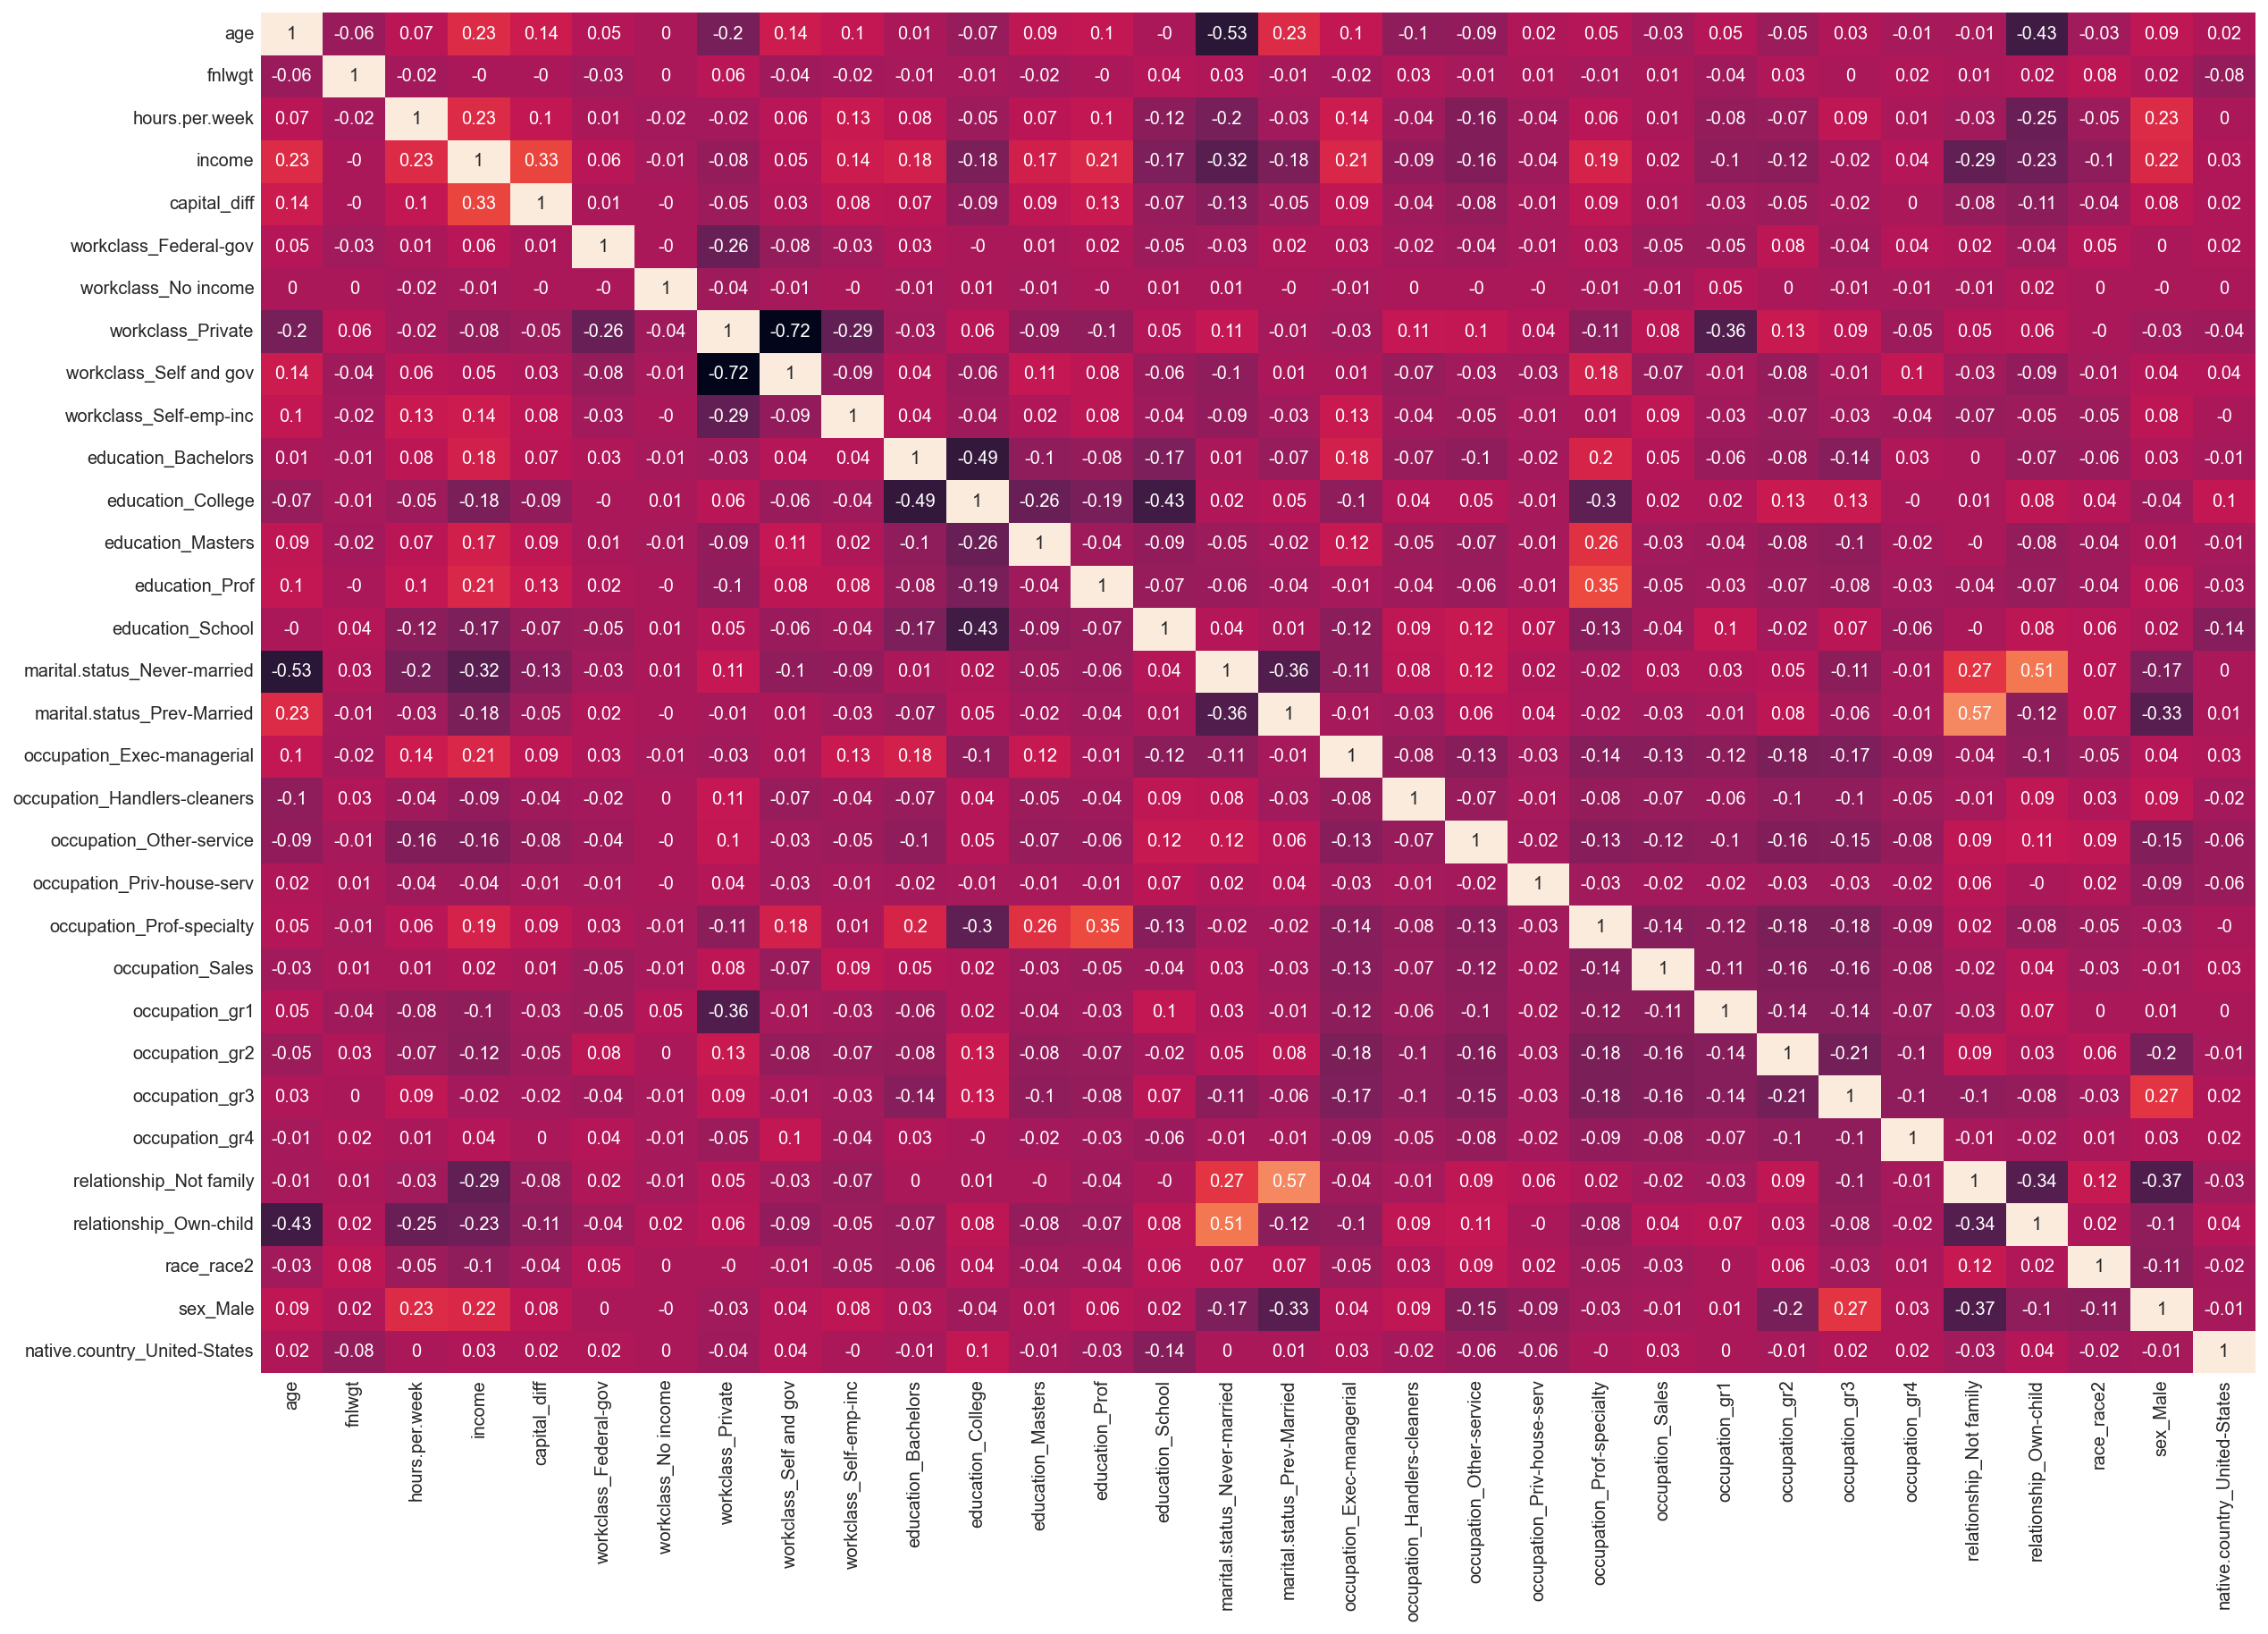

In [21]:
plt.figure(figsize=(20, 14))
sns.heatmap(dummies_data.corr().round(2), annot=True, cbar=False);

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [22]:
X, y = dummies_data.drop(columns=['income']), dummies_data['income']

In [23]:
dummies_data['income'].value_counts(True)

income
0    0.75919
1    0.24081
Name: proportion, dtype: float64

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. 

Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)

In [25]:
y_train.value_counts(True)

income
0    0.759175
1    0.240825
Name: proportion, dtype: float64

In [26]:
y_test.value_counts(True)

income
0    0.759251
1    0.240749
Name: proportion, dtype: float64

После стратифицированного разбиения сравнил распределение классов в разделенных выборках. Распределение такое же как и у всей выборки.

Производим нормализацию данных с помощью min-max нормализации.

Нормализация нужна, большинство алгоритмов (на вскиду за исключением деревьев решений) плохо работает без нормлаизации разных признаков к одной шкале.

Статистический градиентый спуск не работает без нормализации.

In [27]:
scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Моделирование + оценка модели

#### Логистическая регрессия

**Модель логистической регрессии:**

Модель логистической регрессии имеет следующий вид:
$$z_i= w_0+\sum_{j=0}^m w_j x_{ij}$$

$$\widehat{P_i}= \frac{1}{1+exp(-z_i)}$$

$$\widehat{y_i} = I_\gamma[\widehat{P_i}]$$

где $x_{ij}$ — объект из $i$-ой строки и $j$-ого столбца из таблицы объектов-признак $X$, $y_i$ — правильный ответ, соответствующий $x_{i}$, $\omega$ — параметры логистической регрессии, $\widehat{P_i}$ - вероятность принадлежности к классу, $\gamma$ - порог вероятности (стандартный - 0.5)

Для поиска параметров модели используется схема минизации эмпиричного риска - ищутся такие параметры $\omega$, при которых функция ошибки $L(\omega)$ была бы минимальна. 


В качестве функции потерь используем logloss - логистическая функция потерь.

$$L(\omega) = logloss = -\sum_{i=1}^{n}{(y_i log(\widehat{P_i}) + (1-y_i)log(1-\widehat{P_i}))} \Rightarrow min_\omega $$

Поиск параметров можно проводить с помощью численных методов. Например, градиентного спуска

In [28]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', # алгоритм оптимизации
    random_state=1, # генератор случайных чисел
    max_iter=1000 # количество итераций на сходимость
)

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='sag')

Выводим отчет по метрикам для тренировочной и тестовой выборок

In [29]:
# Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)

print('TRAIN:')
# Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
# Делаем предсказание для тестовой выборки

print('TEST:')
y_test_pred = log_reg.predict(X_test_scaled)
# Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

TRAIN:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     19775
           1       0.72      0.58      0.64      6273

    accuracy                           0.84     26048
   macro avg       0.80      0.75      0.77     26048
weighted avg       0.84      0.84      0.84     26048

TEST:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4945
           1       0.72      0.58      0.64      1568

    accuracy                           0.84      6513
   macro avg       0.80      0.75      0.77      6513
weighted avg       0.84      0.84      0.84      6513



In [30]:
# Строим матрицы ошибок для каждой из моделей
confusion_matrix_train = metrics.confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_pred)

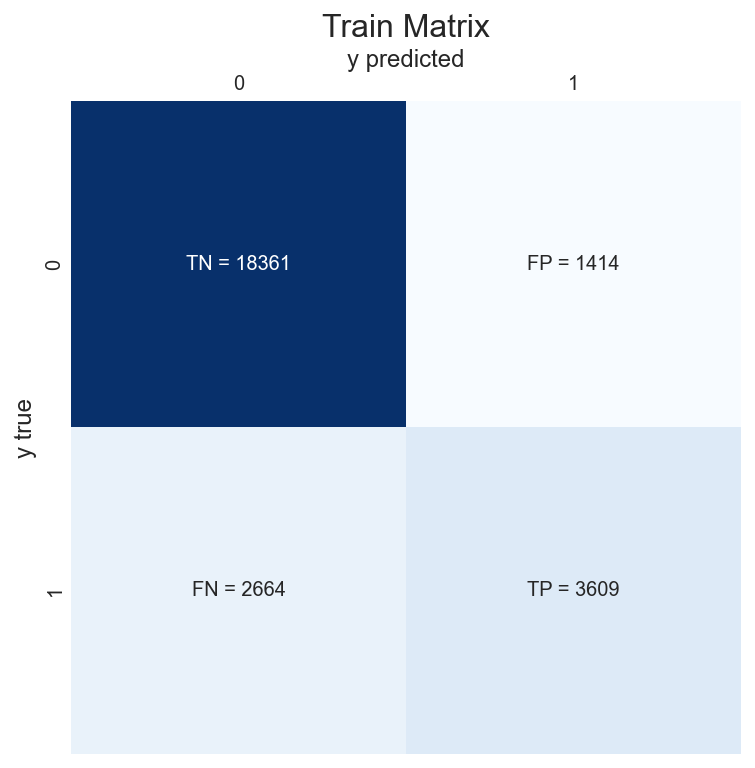

In [31]:
hd.plot_confusion_matrix(confusion_matrix_train, 'Train Matrix')

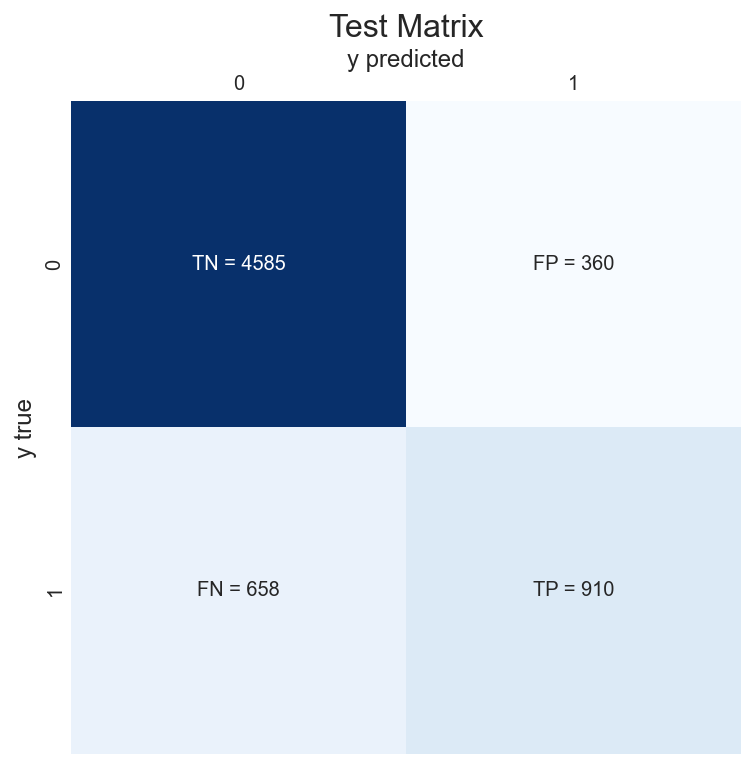

In [32]:
hd.plot_confusion_matrix(confusion_matrix_test, 'Test Matrix')

Вывожу только нужные метрики для задачи несбалансированных классов

In [33]:
print('TRAIN metrics:')
print('Precision: {:.2f}'.format(metrics.precision_score(y_train, y_train_pred)))
print('Recall: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print()
print('TEST metrics:')
print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

TRAIN metrics:
Precision: 0.72
Recall: 0.58
F1 score: 0.64

TEST metrics:
Precision: 0.72
Recall: 0.58
F1 score: 0.64


### Настройка порога вероятности
Сделаем предсказание вероятности высокого дохода моделью log_reg. Затем создадим несколько различных порогов вероятности в диапазоне от 0.1 до 1 с шагом 0.05. 

В цикле будем определять класс дохода при различных порогах вероятности. В конце рассчитаем метрики.

#### Расчет делаем и подбор порога делаем на тествой части, это фактически гиперпараметр очередной.
А проверка должна идти на третьей, валидационной выборке.

In [34]:
# Считаем вероятности высокого дохода
# Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg.predict_proba(X_test_scaled)[:, 1]

# Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)

# Создадим списки, в которых будем хранить значения метрик 
precision_scores = []
recall_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.05, 0.95, 0.025)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Людей, для которых вероятность нвысокого дохода > threshold относим к классу 1
    # В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики и добавляем их в списки
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

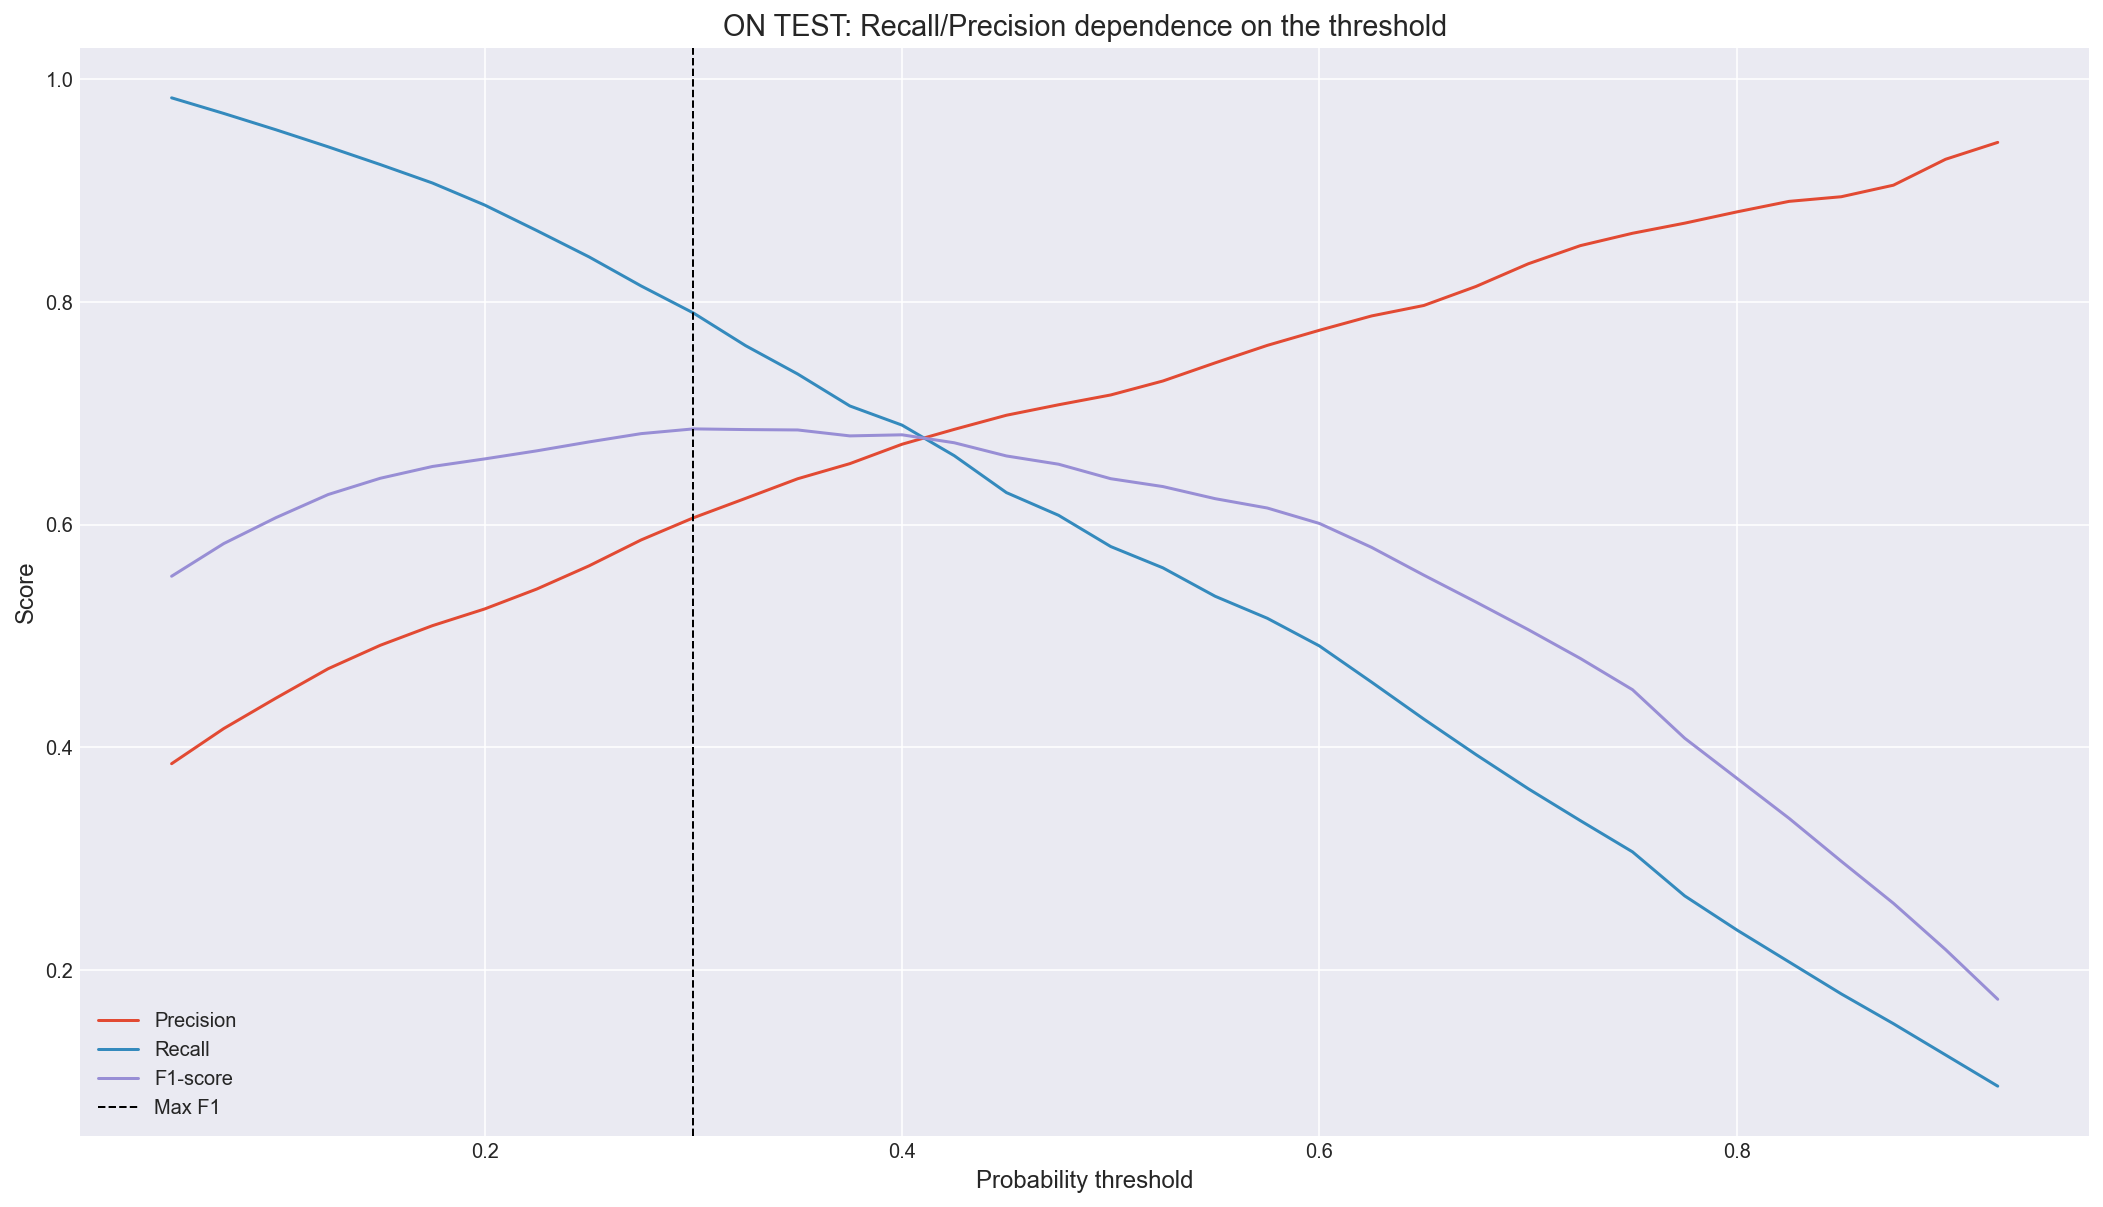

In [35]:
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(18, 10)) # фигура + координатная плоскость

# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')

# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# Add vertical line
max_threshold = thresholds[np.argmax(f1_scores)]
ax.axvline(x=max_threshold, color='black', linestyle='--', linewidth=1, label='Max F1')

# Даем графику название и подписи осям
ax.set_title('ON TEST: Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

### Я подумал брать значение порога по F1, а вот лектор предлагает брать значение пересечения всех 3х метрик 

In [36]:
# Задаем оптимальный порог вероятностей по максимуму F1
threshold_opt = round(max_threshold, 2)

# Людей, у которых вероятность зарабатывать >50K больше threshold_opt относим к классу 1

# В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      4945
           1       0.61      0.79      0.69      1568

    accuracy                           0.83      6513
   macro avg       0.77      0.81      0.78      6513
weighted avg       0.85      0.83      0.83      6513



# Дерево решений

Дерево решений - ациклический связный граф. 

Построение дерева решений происходит по рекурсивному алгоритму $CART$ (псевдокод приведен в модуле).

В каждой вершине дерева задается решающее правило или предикат вида:

$$B_v(j, t) = I[x_j<= t]$$

Где $B_v$ - предикат в вершине под номер $v$, $j$ - номер признака, $t$ - пороговое значение признака 
Предикат разделяет выборку на две части: $Q_{left}$ - для которой условие верно, и $Q_{right}$ - для которой условие ложно.

На основе разделения выборки вершина порождает все новые вершины: левую и правую, для каждой из которых алгоритм повторяется, пока не выполнится некоторый критерий остановки.

Критерии остановки:
* достигнутая максимальная глубина (max_depth)
* количество наблюдений в листе меньше заданного числа (min_sample_leaf)
* неопределенность (функция ошибки) $L(j, t)$ в вершине равна 0 - все объекты, попавшие в вершину принадлежат одному классу.



Параметры $j$ и $t$ подбираются полным перебором (в sklearn он оптимизированы). Из всех возможных значений выбираются такие параметры, при которых функция ошибки (суммарная неопределенность) минимальна:
$$L(j, t)= \frac{n^{left}_v}{n_v} H(Q_{left}) + \frac{n^{right}_v}{n_v} H(Q_{right})  \Rightarrow min_{j, t} $$

Где $n^{left}_v$ и $n^{right}_v$ - размер выборок, попавших в левую и правую вершину соответственно 

$H(Q)$ называется критерием информативности. И он может быть двух видов:
1. Энтропия Шеннона:
$$H(Q) = \sum_{i=1}^{k}P_i log_2{P_i} $$
2. Критерий Джини:
$$H(Q) = \sum_{i=1}^{k}P_i (1-P_i) $$

### Задание 7.1
Обучите на обучающей выборке дерево решений с максимальной глубиной 8. 

В качестве критерия информативности используйте энтропию Шеннона. 

Минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Сделайте предсказания для тренировочной и тестовой выборок.

In [37]:
# Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=10,
    max_depth=8,
    random_state=42
)

# Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)

# Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.61
Test: 0.61


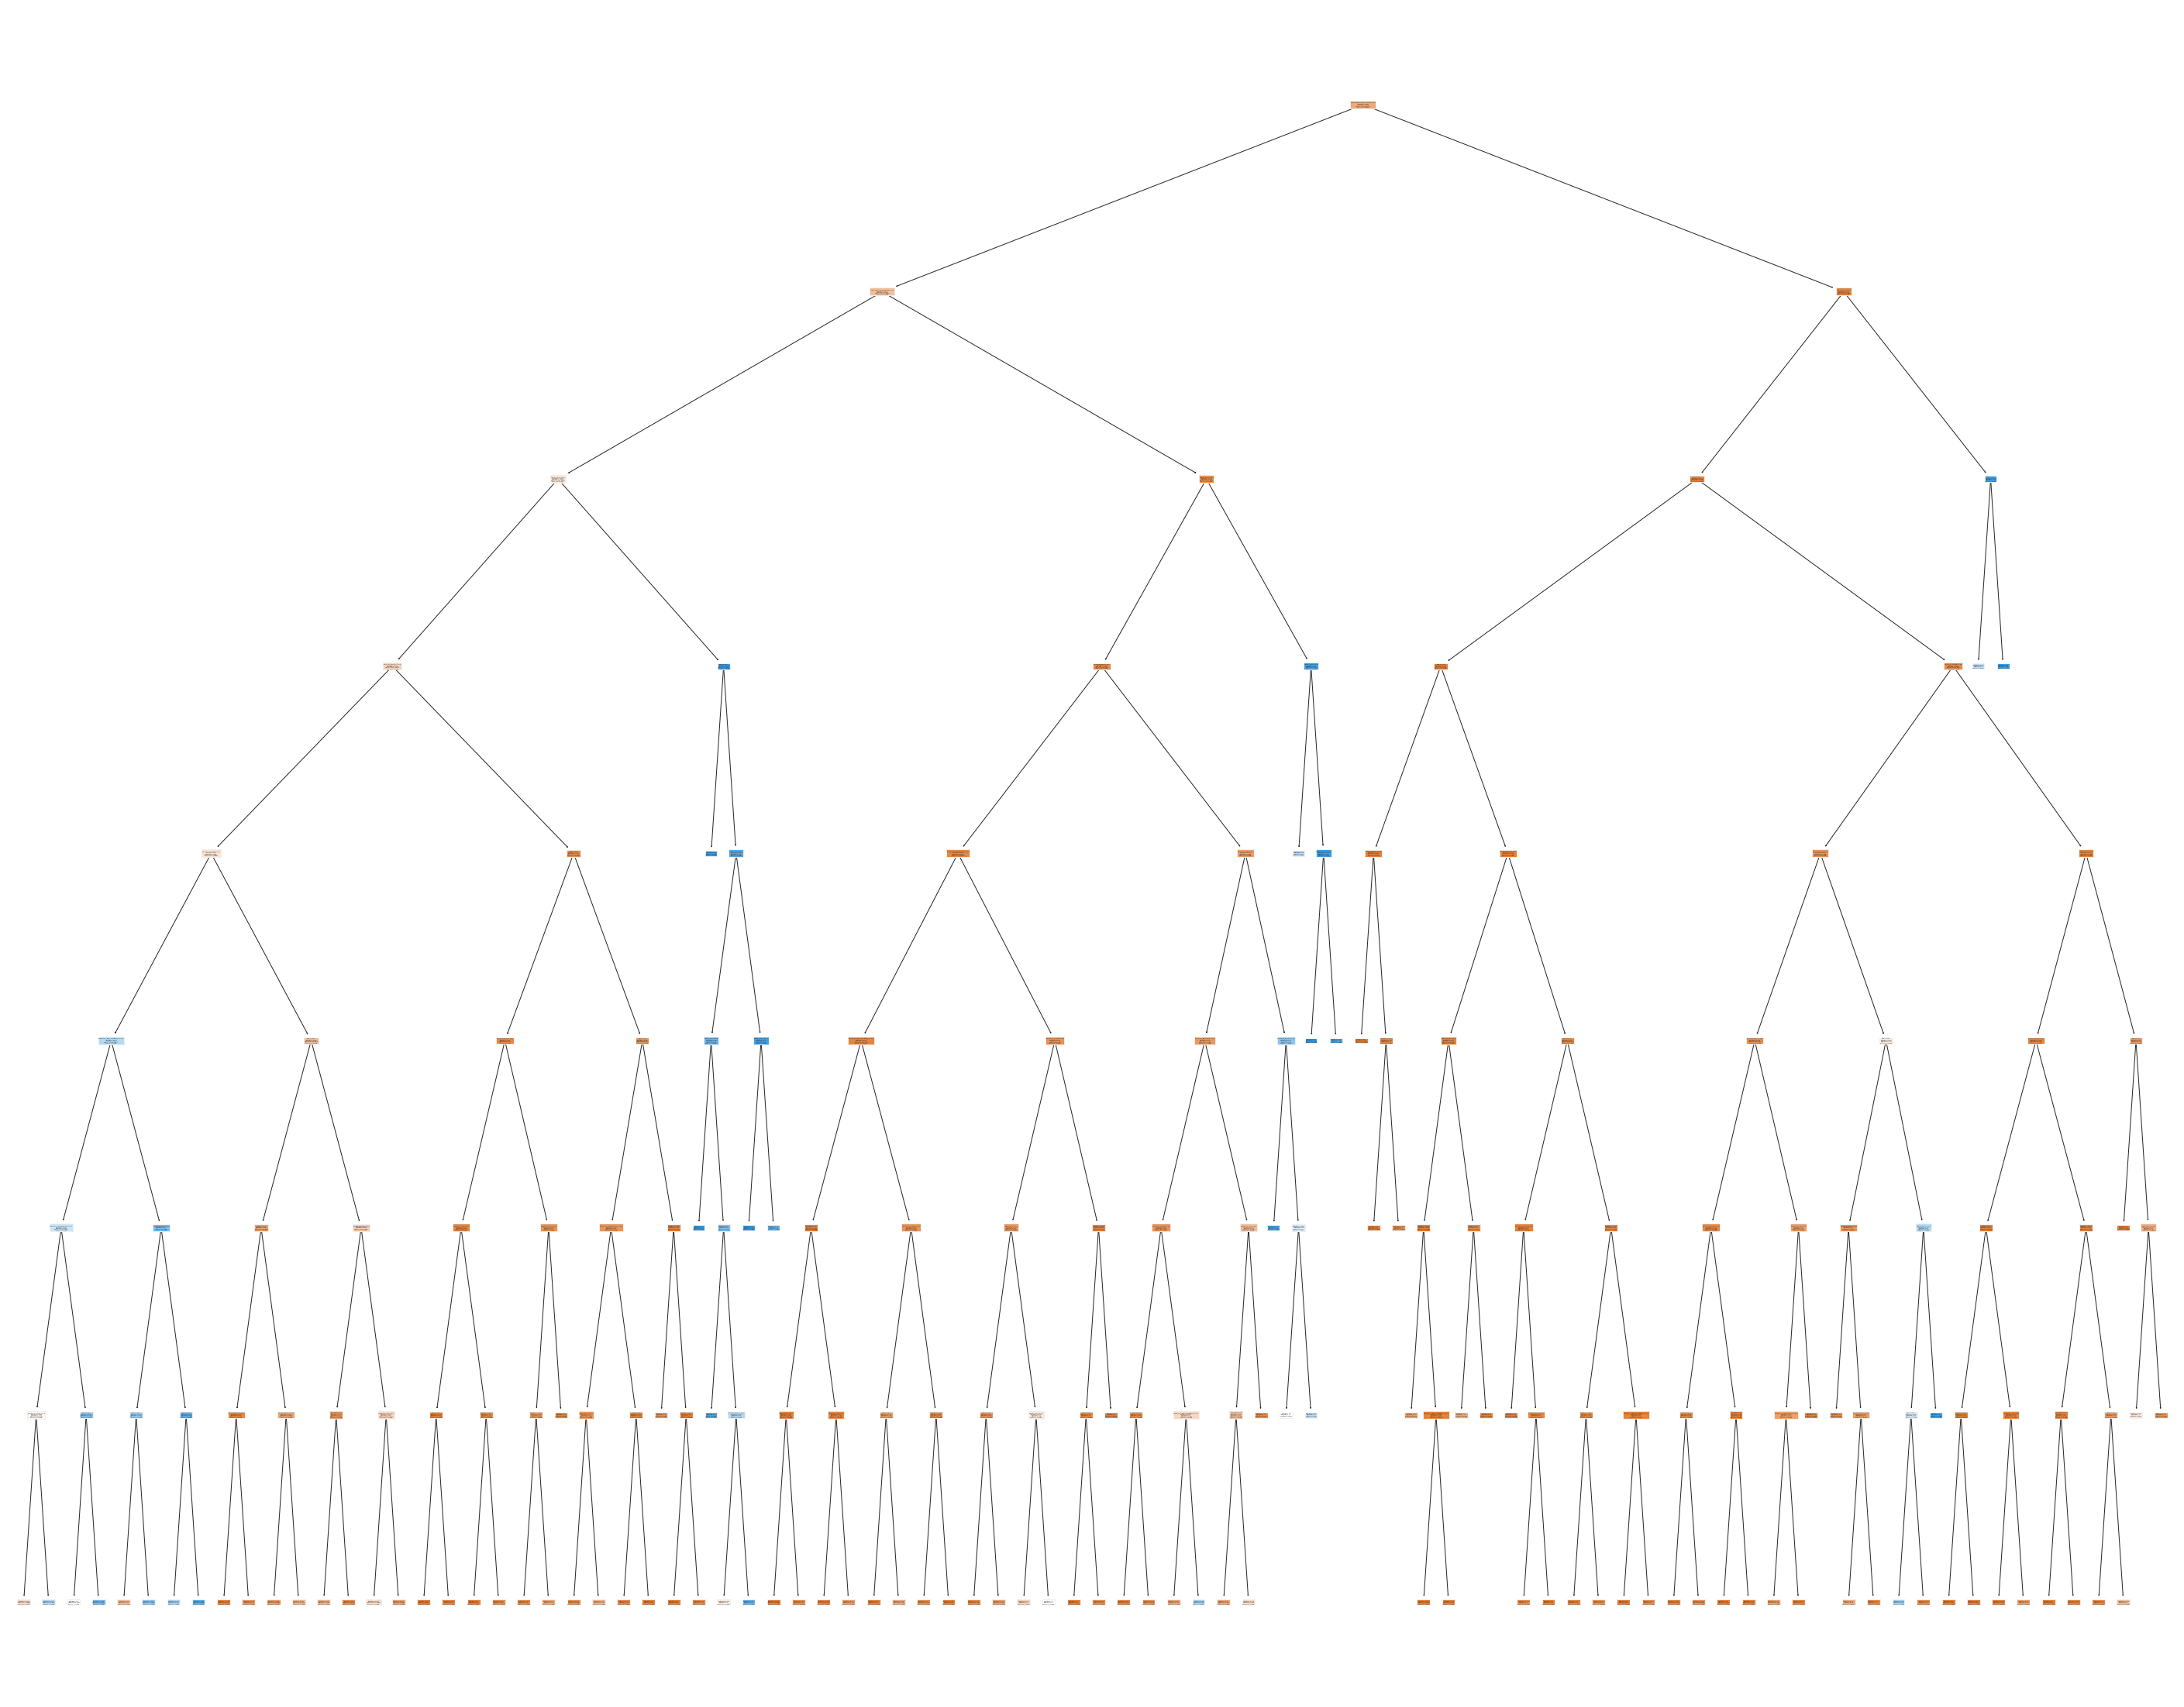

In [38]:
# Создаем фигуру для визуализации графа
fig = plt.figure(figsize=(25,20))
# Строим граф дерева решений
tree_graph = tree.plot_tree(
    dt, # объект обученного дерева
    feature_names=X_train.columns, # наименования факторов
    class_names=["0 - <=50K", "1 - >50K"], # имена классов
    filled=True, # расцветка графа
);

# Бэггинг. Случайный лес

**Бэггинг (bagging)** - алгоритм построения ансамбля путем параллельного обучения множества независимых друг от друга моделей. Предсказание для новых данных производится путем мажоритарного голосования или усреднения ответов

**Случайный лес (Random Forest)** - частный случай бэггинга над деревьями решений с методом случайных подпространств

In [42]:
# Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)
# Обучаем модель
rf.fit(X_train, y_train)

# Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.68
Test: 0.67


In [45]:
# Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
# Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)

# Создадим списки, в которых будем хранить значения метрик 
precision_scores = []
recall_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    # В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    # Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

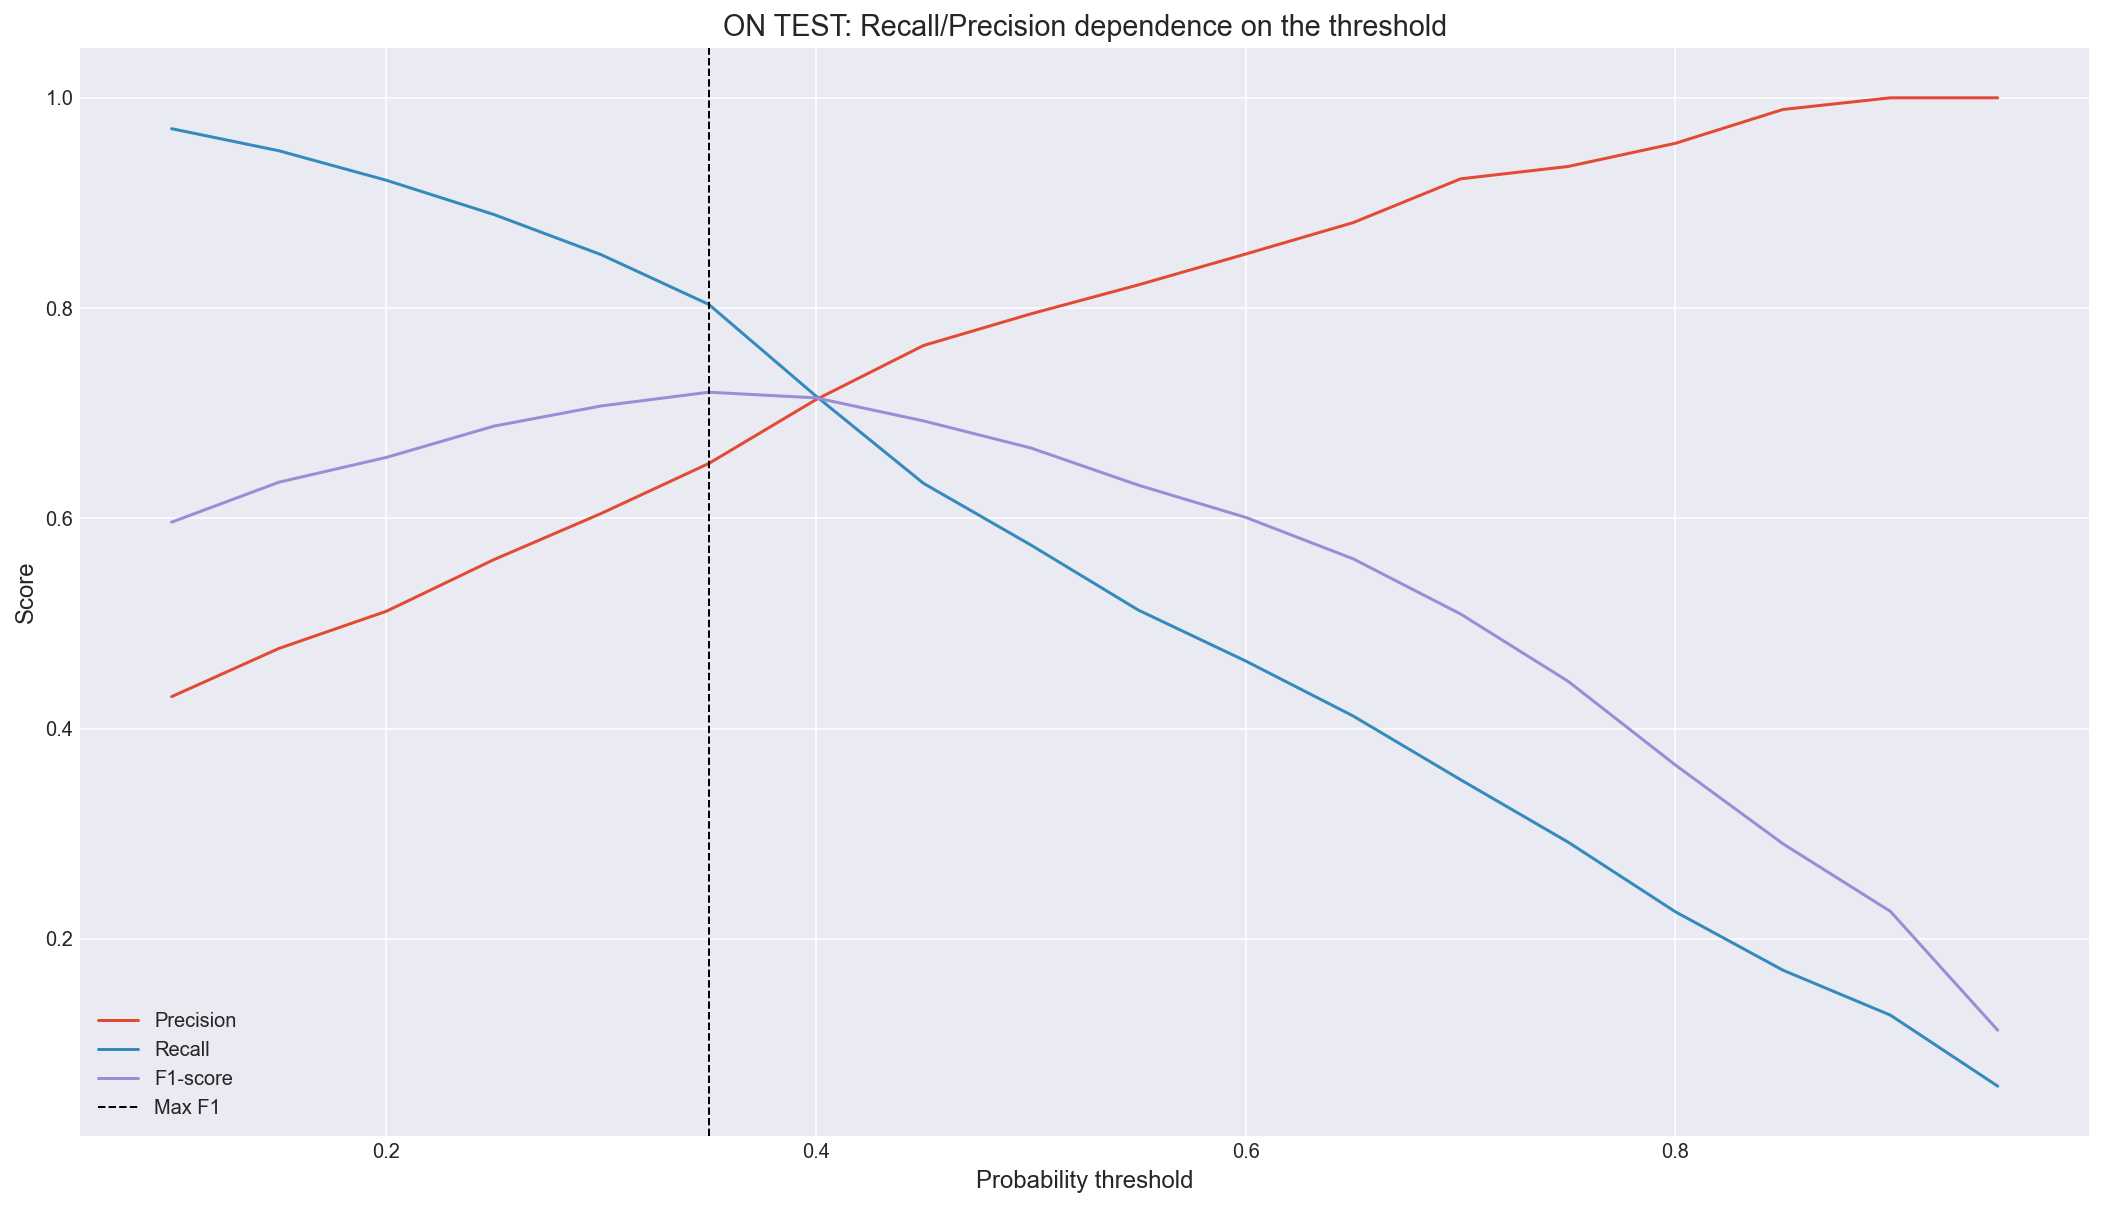

In [46]:
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(18, 10)) # фигура + координатная плоскость

# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')

# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# Add vertical line
max_threshold = thresholds[np.argmax(f1_scores)]
ax.axvline(x=max_threshold, color='black', linestyle='--', linewidth=1, label='Max F1')

# Даем графику название и подписи осям
ax.set_title('ON TEST: Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [ ]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Людей, у которых вероятность зарабатывать >50K больше 0.5 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      4945
           1       0.66      0.78      0.71      1568

    accuracy                           0.85      6513
   macro avg       0.79      0.83      0.81      6513
weighted avg       0.86      0.85      0.85      6513

